# Análise Exploratória de Dados
## Importando bibliotecas

In [1]:
from src.data import prepare
from src.data import process
from src.data import visualize

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import re
import string

from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud
from PIL import Image

plt.style.use('seaborn-notebook')
%matplotlib inline

import matplotlib
matplotlib.rcParams["figure.dpi"] = 300

## Carregando os dados

In [2]:
true_path = "../data/raw/full_texts/true/"
fake_path = "../data/raw/full_texts/fake/"
output_path = "../data/interim/news.csv"

#prepare.make_text_dataframe(true_path, fake_path, output_path)

## Importando dados pré-processados

In [3]:
news_df = pd.read_csv(output_path)
news_df.sample(10)

,text,label
2178,Cantor Victor vira réu em processo que apura s...,true
722,As mulheres que comandam uma das maiores ocupa...,true
4846,"""Meu cliente não pode ser preso porque ele é m...",fake
4325,"Reale Junior: "" O PT não é vítima de um golpe....",fake
1498,Se a reforma da Previdência não for votada em ...,true
358,"Segunda-feira, 4 de setembro. Bom dia! Aqui es...",true
2014,"Sexta-feira, 15 de setembro de 2017. Boa noite...",true
4396,Cunha comparece pessoalmente à CCJ e manda rec...,fake
4417,"Mendes: ""A não cassação dos direitos de Dilma ...",fake
3831,"A casa caiu! PF prende o ""homem da mala"". O e...",fake


## Pré-Processamento Básico

### Passando as palavras para minúsculo

In [4]:
news_df['clean_text'] = news_df['text'].apply(lambda x: x.lower())
news_df.sample(10)

,text,label,clean_text
2212,Marina anuncia pré-candidatura à Presidência. ...,true,marina anuncia pré-candidatura à presidência. ...
4090,Tremor de terra de 2.9 graus é registrado em á...,fake,tremor de terra de 2.9 graus é registrado em á...
2780,Seul treina time para decapitar ditador vizinh...,true,seul treina time para decapitar ditador vizinh...
2028,O ex-deputado Pedro Corrêa (ex-PP) afirmou qu...,true,o ex-deputado pedro corrêa (ex-pp) afirmou qu...
748,MP abre inquérito que pode cassar direitos pol...,true,mp abre inquérito que pode cassar direitos pol...
3675,"Médico dá ultimato para Ana Maria Braga: ""Ou l...",fake,"médico dá ultimato para ana maria braga: ""ou l..."
3510,"Eduardo Cunha volta a cumprir pena no Paraná, ...",true,"eduardo cunha volta a cumprir pena no paraná, ..."
6116,Urgente: Renan abre votação para o PL 280 (abu...,fake,urgente: renan abre votação para o pl 280 (abu...
3982,"Época faz denúncia grave: ""Figurões do PT pode...",fake,"época faz denúncia grave: ""figurões do pt pode..."
3852,Jornalista petista é condenado a 5 meses e 10 ...,fake,jornalista petista é condenado a 5 meses e 10 ...


### Removendo datas
#### Formato dd/mm/YYYY

In [5]:
news_df['clean_text'] = process.remove_date(news_df.clean_text) 

/home/tayna/Documents/profissional/academico/cursos/atlantico2022/fake-news-detector/src/data/process.py:34: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  size = text_series[text_series.str.contains(pattern)].size


Modificando 103 linhas contendo este padrão.


#### Formato dd de mês de YYYY

In [6]:
#remove datas no formato dd de mês de YYYY
news_df['clean_text'] = process.remove_date(news_df.clean_text, style='diamesextensoano')

Modificando 643 linhas contendo este padrão.


#### Dias da semana

In [7]:
# remove dias da semana
news_df['clean_text'] = news_df['clean_text'].apply(lambda c: process.remove_weekday(c))
#news_df['clean_clean_text']
news_df.sample(10)

,text,label,clean_text
4059,"Neymar recebe ""perdão"" da Receita Federal e dí...",fake,"neymar recebe ""perdão"" da receita federal e dí..."
1858,Temer diz que recebeu de publicitário orientaç...,true,temer diz que recebeu de publicitário orientaç...
4509,"General manda recado aos políticos: ""Não dá pr...",fake,"general manda recado aos políticos: ""não dá pr..."
6400,Juiz da Lava Jato esvazia celas da PF em Curit...,fake,juiz da lava jato esvazia celas da pf em curit...
5992,"Deputado Federal afirma no plenário: ""Lula é o...",fake,"deputado federal afirma no plenário: ""lula é o..."
1796,Tribunal Regional Federal derruba decisão que ...,true,tribunal regional federal derruba decisão que ...
636,Smartphones nos espionam e ainda pagamos por e...,true,smartphones nos espionam e ainda pagamos por e...
60,Pais de taxista atingido por Airbus da TAM em ...,true,pais de taxista atingido por airbus da tam em ...
4187,Aécio fez 110 viagens para Cláudio/MG (aeropor...,fake,aécio fez 110 viagens para cláudio/mg (aeropor...
2797,﻿O Podemos decidiu expulsar o deputado federa...,true,﻿o podemos decidiu expulsar o deputado federa...


### Removendo caracteres especiais
#### '\n'

In [8]:
news_df['clean_text'] = process.remove_linebreaks(news_df.clean_text)

Modificando 577 linhas contendo este padrão.


In [9]:
news_df['clean_text'][news_df['clean_text'].str.contains('\t')]

623     tiririca faz primeiro discurso na câmara para ...
2735     a força-tarefa da operação lava jato pediu em...
6397    kátia abreu diz que vai colocar sua expulsão e...
Name: clean_text, dtype: object

In [10]:
news_df['clean_text'].iloc[[623, 2735, 6397]].str.findall('\t')

623                         [\t]
2735    [\t, \t, \t, \t, \t, \t]
6397                        [\t]
Name: clean_text, dtype: object

In [11]:
news_df['clean_text'] = process.remove_tabs(news_df.clean_text)

Modificando 3 linhas contendo este padrão.


### Removendo pontuação

In [12]:
punctuation = list(string.punctuation) # Obtendo os caracteres especiais como lista
del(punctuation[12]) # Excluindo da remoção o caractere especial "-"
punctuation = "".join(punctuation) # Transformando novamente em string
punctuation

'!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [13]:
news_df['clean_text'] = news_df['clean_text'].apply(lambda c: re.sub('[%s]' % re.escape(punctuation), '', c))
news_df.sample(10)

,text,label,clean_text
5262,Casa Branca promete apoiar o Brasil e diz que ...,fake,casa branca promete apoiar o brasil e diz que ...
61,Tribunal nega liberdade para ex-gerente de Eng...,true,tribunal nega liberdade para ex-gerente de eng...
6213,As 6 mentiras cabeludas que Dilma contou para ...,fake,as 6 mentiras cabeludas que dilma contou para ...
3208,"Em ato na Câmara, deputados cobram agilidade n...",true,em ato na câmara deputados cobram agilidade na...
3555,Triplex do Guarujá: o que dizem ex-executivos ...,true,triplex do guarujá o que dizem ex-executivos d...
3251,"Lula tem 'excelente estado', sem indícios do c...",true,lula tem excelente estado sem indícios do cânc...
3230,Meu Direto ao Assunto abriu o Podcast Comenta...,true,meu direto ao assunto abriu o podcast comenta...
6445,Coreia flagra submarino americano em radar e d...,fake,coreia flagra submarino americano em radar e d...
3184,Lula diz que Lava Jato já tem a tese pronta e ...,true,lula diz que lava jato já tem a tese pronta e ...
4378,"O MITO: Aos 86 anos, apresentador surpreende....",fake,o mito aos 86 anos apresentador surpreende sí...


### Removendo espaços extra

In [14]:
news_df['clean_text'] = news_df['clean_text'].apply(lambda x: re.sub(' +',' ',x))
news_df['clean_text']

0       jbs pagará r 650 mil de indenização por demiss...
1       motorista envolvido em morte de comissário já ...
2        em propaganda partidária veiculada anteontem ...
3       pgr pede ao stf que reverta decisão do legisla...
4       como o ocidente compreende mal a china apesar ...
                              ...                        
7195    coreia anuncia novo teste nuclear diplomata di...
7196    temer vai punir sergio reis e tiririca por tra...
7197    wikileaks diz que temer era espião dos eua o w...
7198    site divulga que viagem de lula à europa seria...
7199    dilma escorrega em entrevista e confessa que p...
Name: clean_text, Length: 7200, dtype: object

## Analisando os dados obtidos

### Quantidade de dados

In [15]:
news_df['label'].value_counts()

true    3600
fake    3600
Name: label, dtype: int64

*O conjunto de dados do corpus se encontra balanceado. 
Pois há um número igual de amostras (textos) em ambas as classes: verdadeiros (true) e falsos (fake).*

### Comprimento

#### De todo o texto

- Qual o comprimento dos textos obtidos?
- O comprimento dos textos difere entre falsos e verdadeiros?

In [16]:
news_df['text_length'] = news_df['clean_text'].str.len()

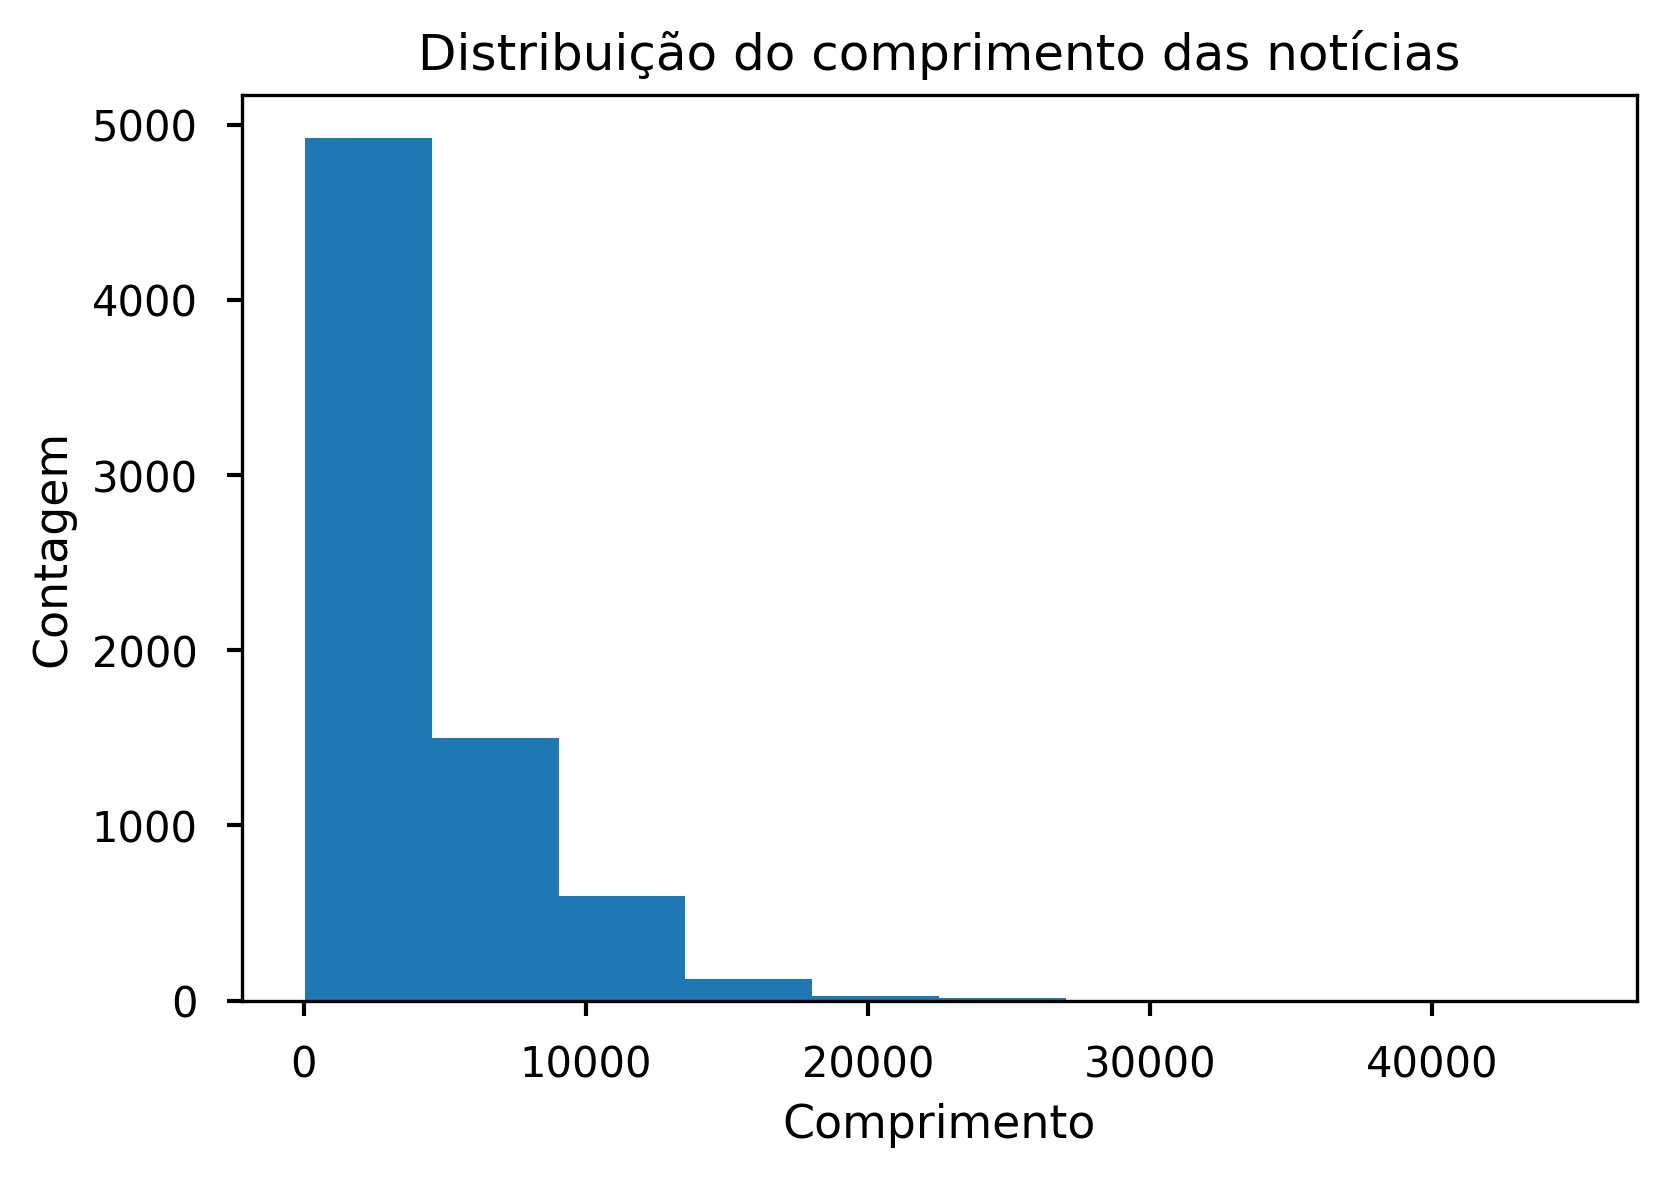

In [17]:
plt.hist(news_df.text_length)
plt.xlabel('Comprimento')
plt.ylabel('Contagem')
plt.title('Distribuição do comprimento das notícias')
plt.show()

In [18]:
news_df.text_length.describe()

count     7200.000000
mean      3777.382361
std       3952.549361
min         43.000000
25%        910.750000
50%       2108.000000
75%       5433.000000
max      44988.000000
Name: text_length, dtype: float64

*A maioria dos textos têm um comprimento pequeno (menos de 5 mil palavras), a partir disso decidimos averiguar a distribuição do comprimento entre notícias verdadeiras e falsas.*

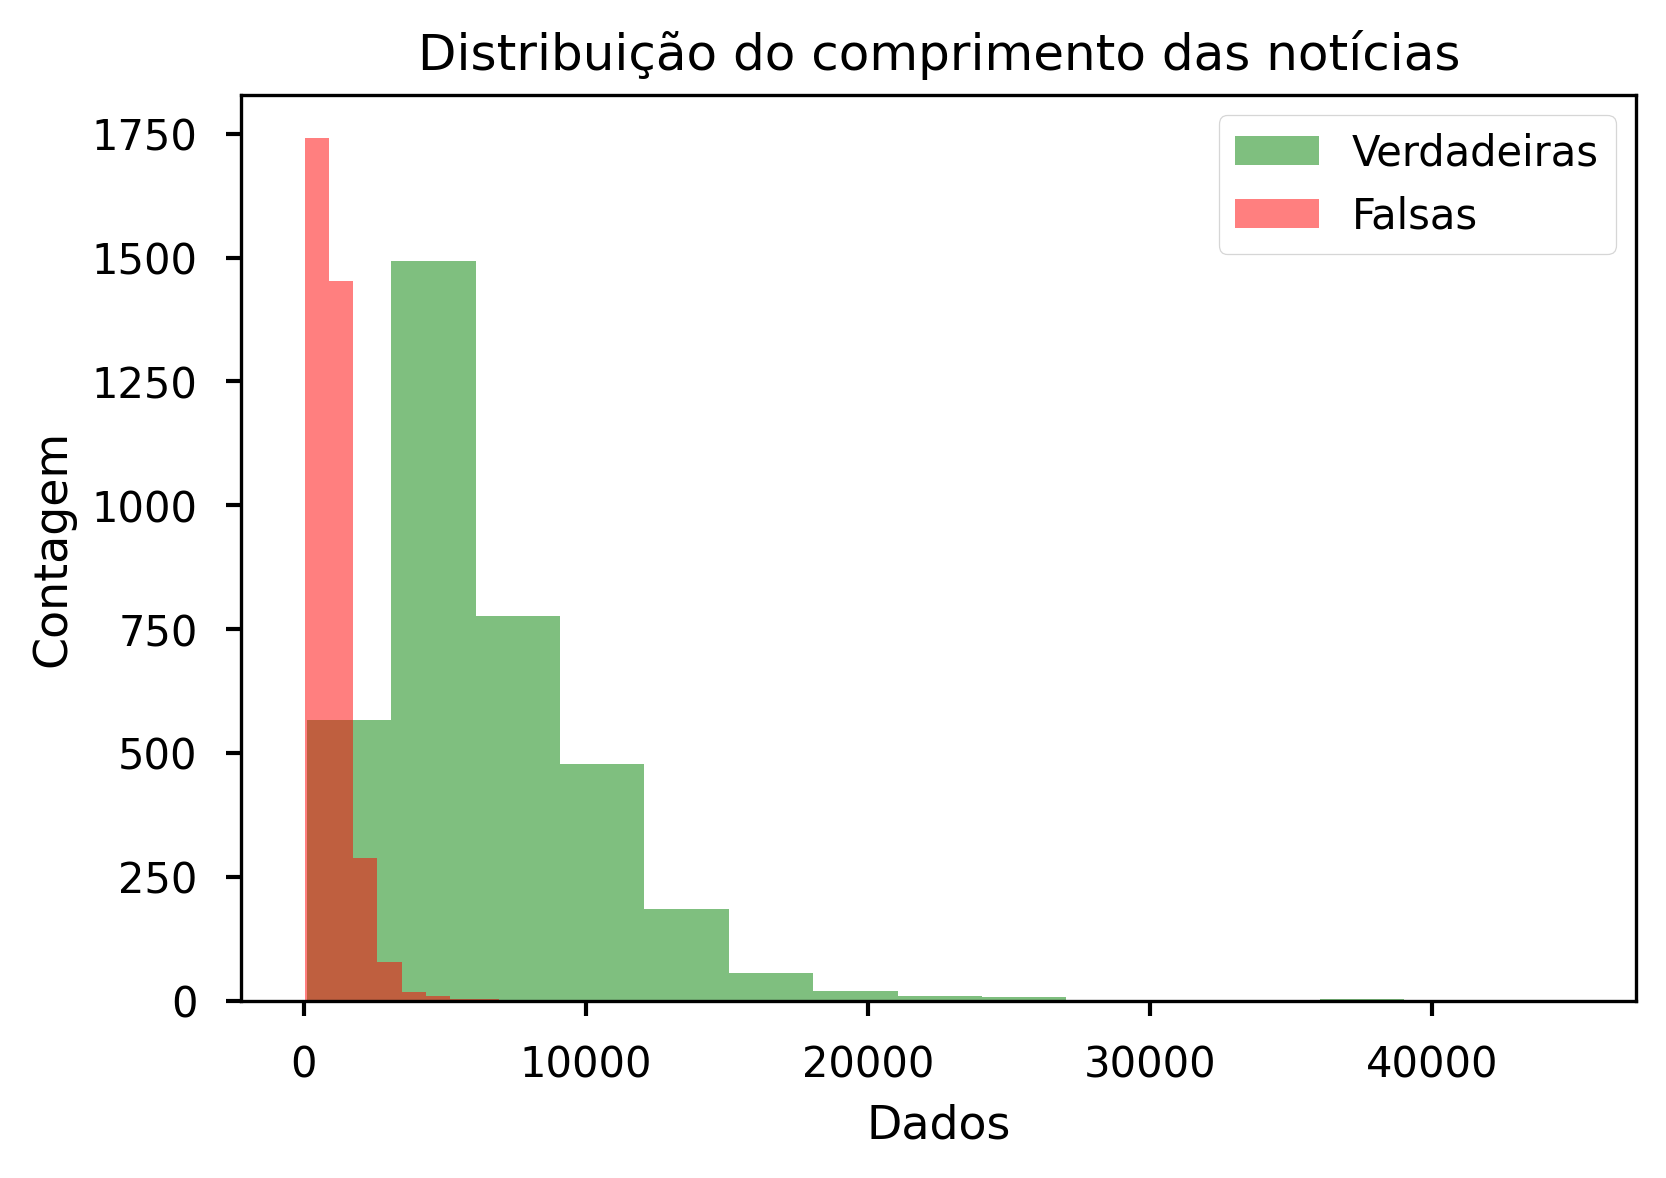

In [19]:
bins = 15
alpha = 0.5

plt.hist(news_df[news_df.label == 'true'].text_length,
         bins=bins,
         alpha=alpha,
         label='Verdadeiras',
         color='green')

plt.hist(news_df[news_df.label == 'fake'].text_length,
         bins=bins,
         alpha=alpha,
         label='Falsas',
         color='red')

plt.xlabel('Dados')
plt.ylabel('Contagem')
plt.title('Distribuição do comprimento das notícias')
plt.legend(loc='upper right')

plt.show()

*As notícias têm entre 46 e cerca de 46000 palavras, se distribuindo de maneira desigual de acordo com sua categoria. O comprimento das notícias verdadeiras tem tamanhos mais variados e mediana superior às notícias falsas, cujo comprimento se concentra numa faixa reduzida.* 

*Dentro desse conjunto de dados, notícias falsas tendem a ser mais curtas.*

#### Das palavras

- Há diferença no tamanho médio das palavras entre as diferentes categorias de notícias?

In [20]:
news_df['mean_word_len'] = (
    news_df['clean_text']
    .str
    .split()
    .apply(lambda text : [len(word) for word in text])
    .map(lambda word: np.mean(word))
)

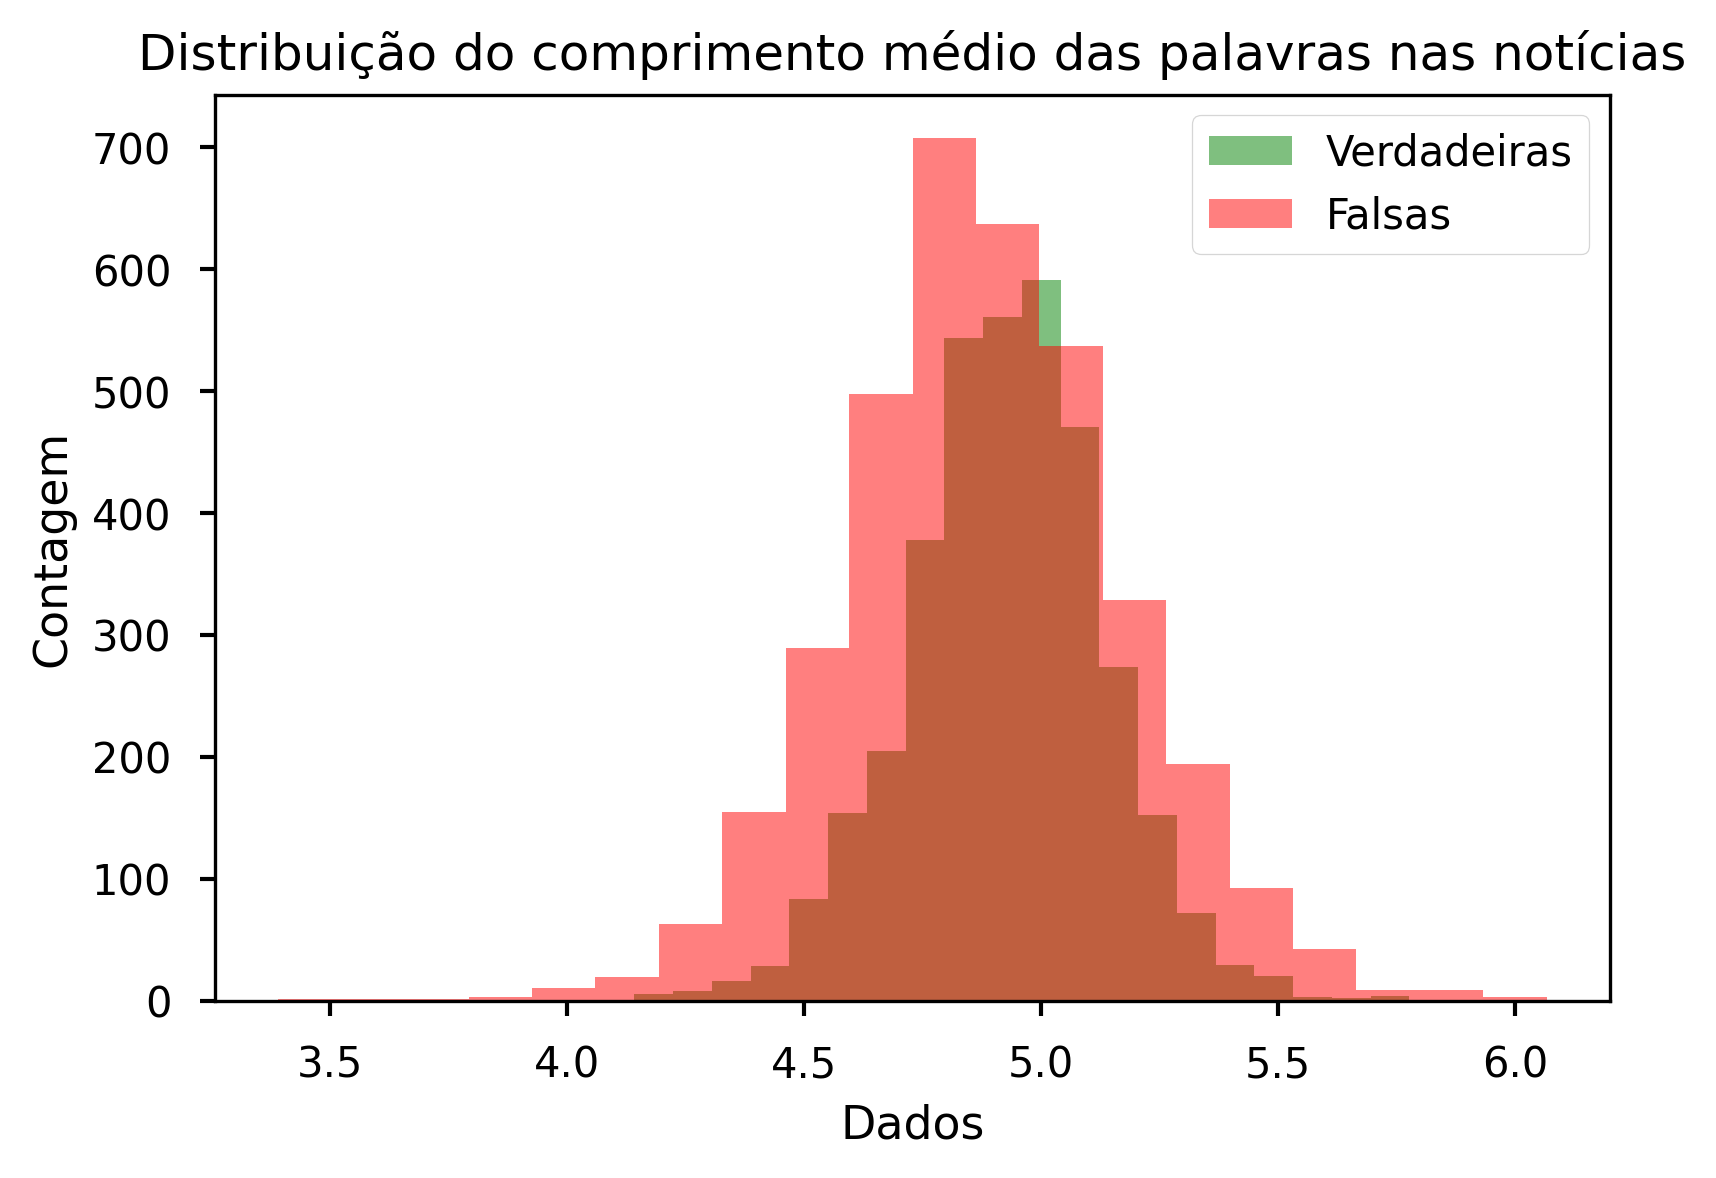

In [21]:
bins = 20
alpha = 0.5

plt.hist(news_df[news_df.label == 'true'].mean_word_len,
         bins=bins,
         alpha=alpha,
         label='Verdadeiras',
         color='green')

plt.hist(news_df[news_df.label == 'fake'].mean_word_len,
         bins=bins,
         alpha=alpha,
         label='Falsas',
         color='red')

plt.xlabel('Dados')
plt.ylabel('Contagem')
plt.title('Distribuição do comprimento médio das palavras nas notícias')
plt.legend(loc='upper right')

plt.show()

*Podemos observar um ligeiro deslocamento entre a média dos dados das notícias falsas e verdadeiras, apesar curva da distribuição se apresentar de maneira similar. Esta semelhança pode advir do fato de notícias de ambas categorias apresentarem a mesma temática e por tanto se utilizarem dos mesmos vocábulos.*

### Número de palavras

In [22]:
news_df['text_size'] = (
    news_df['clean_text']
    .str
    .split()
    .str
    .len()
)

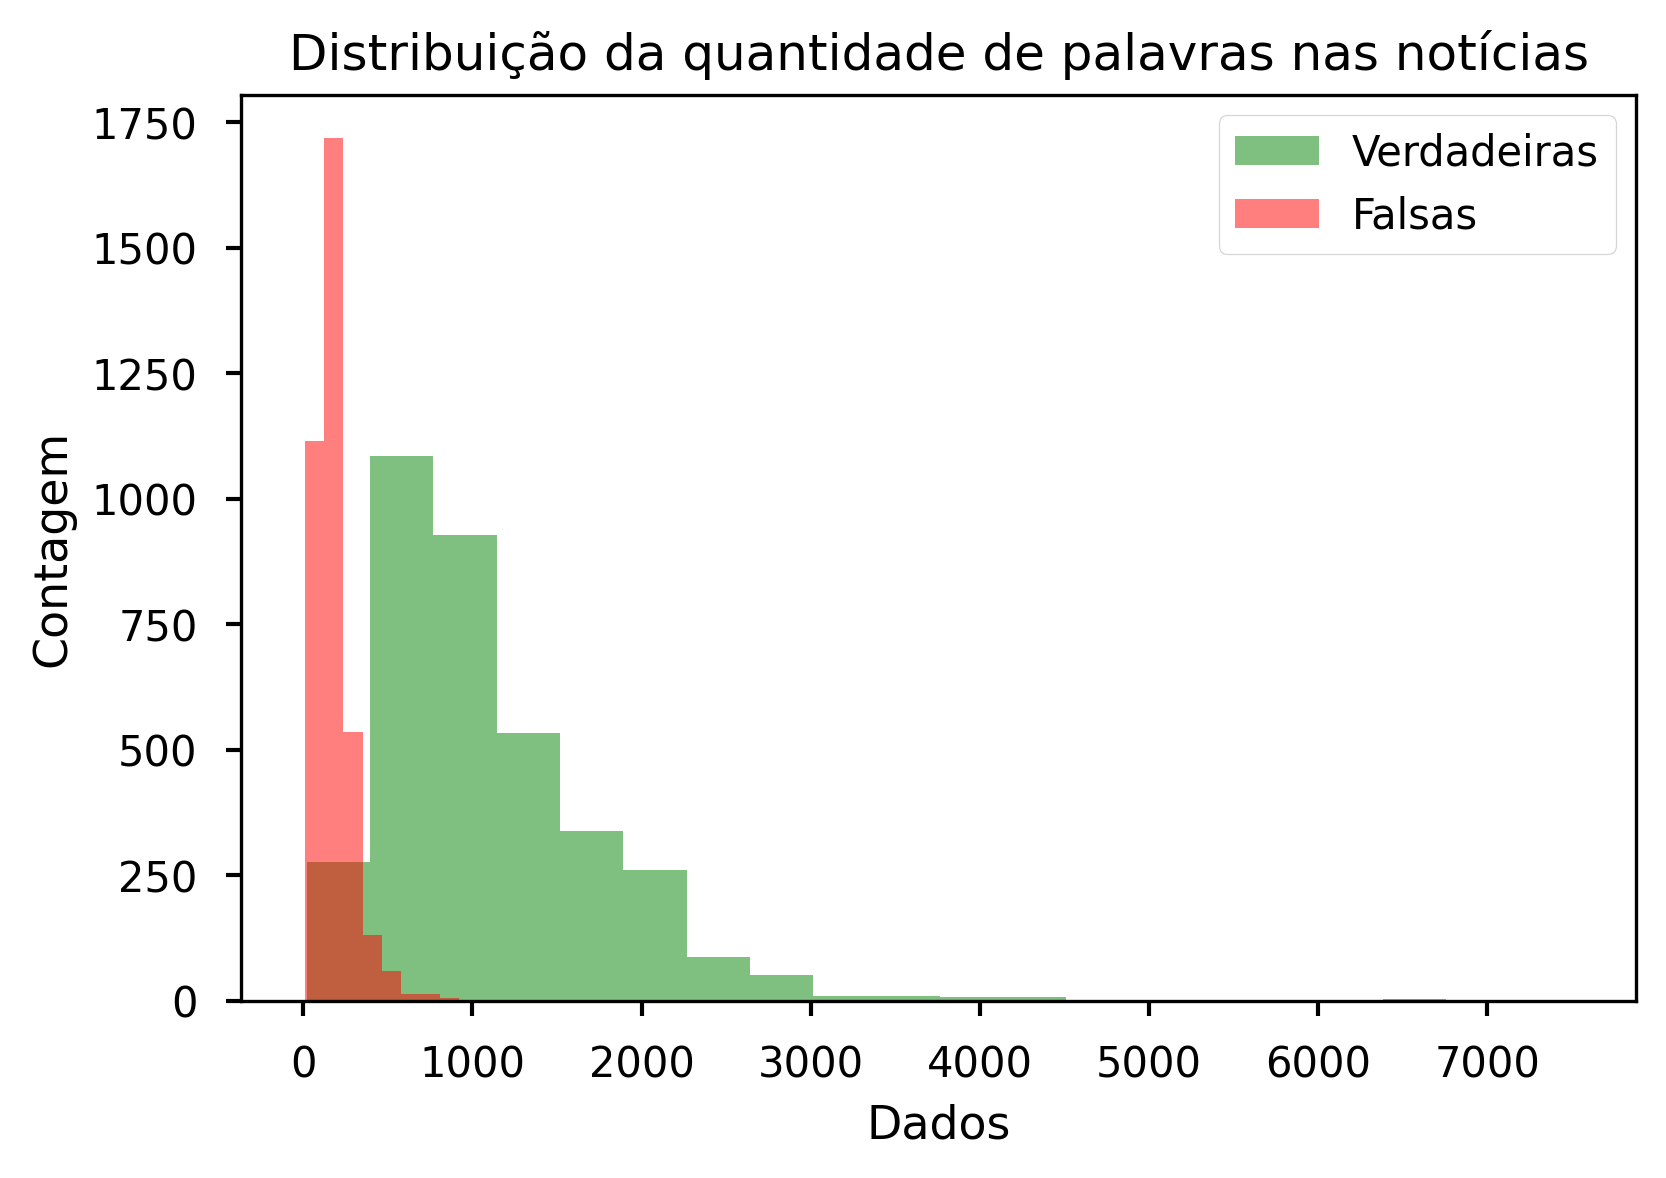

In [23]:
bins = 20
alpha = 0.5

plt.hist(news_df[news_df.label == 'true'].text_size,
         bins=bins,
         alpha=alpha,
         label='Verdadeiras',
         color='green')

plt.hist(news_df[news_df.label == 'fake'].text_size,
         bins=bins,
         alpha=alpha,
         label='Falsas',
         color='red')

plt.xlabel('Dados')
plt.ylabel('Contagem')
plt.title('Distribuição da quantidade de palavras nas notícias')
plt.legend(loc='upper right')

plt.show()

### Nuvens de palavras
- As palavras mais usadas nas notícias abordadas estão dentro dos mesmos campos semânticos?

In [24]:
nltk.download('stopwords')
stop = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to /home/tayna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


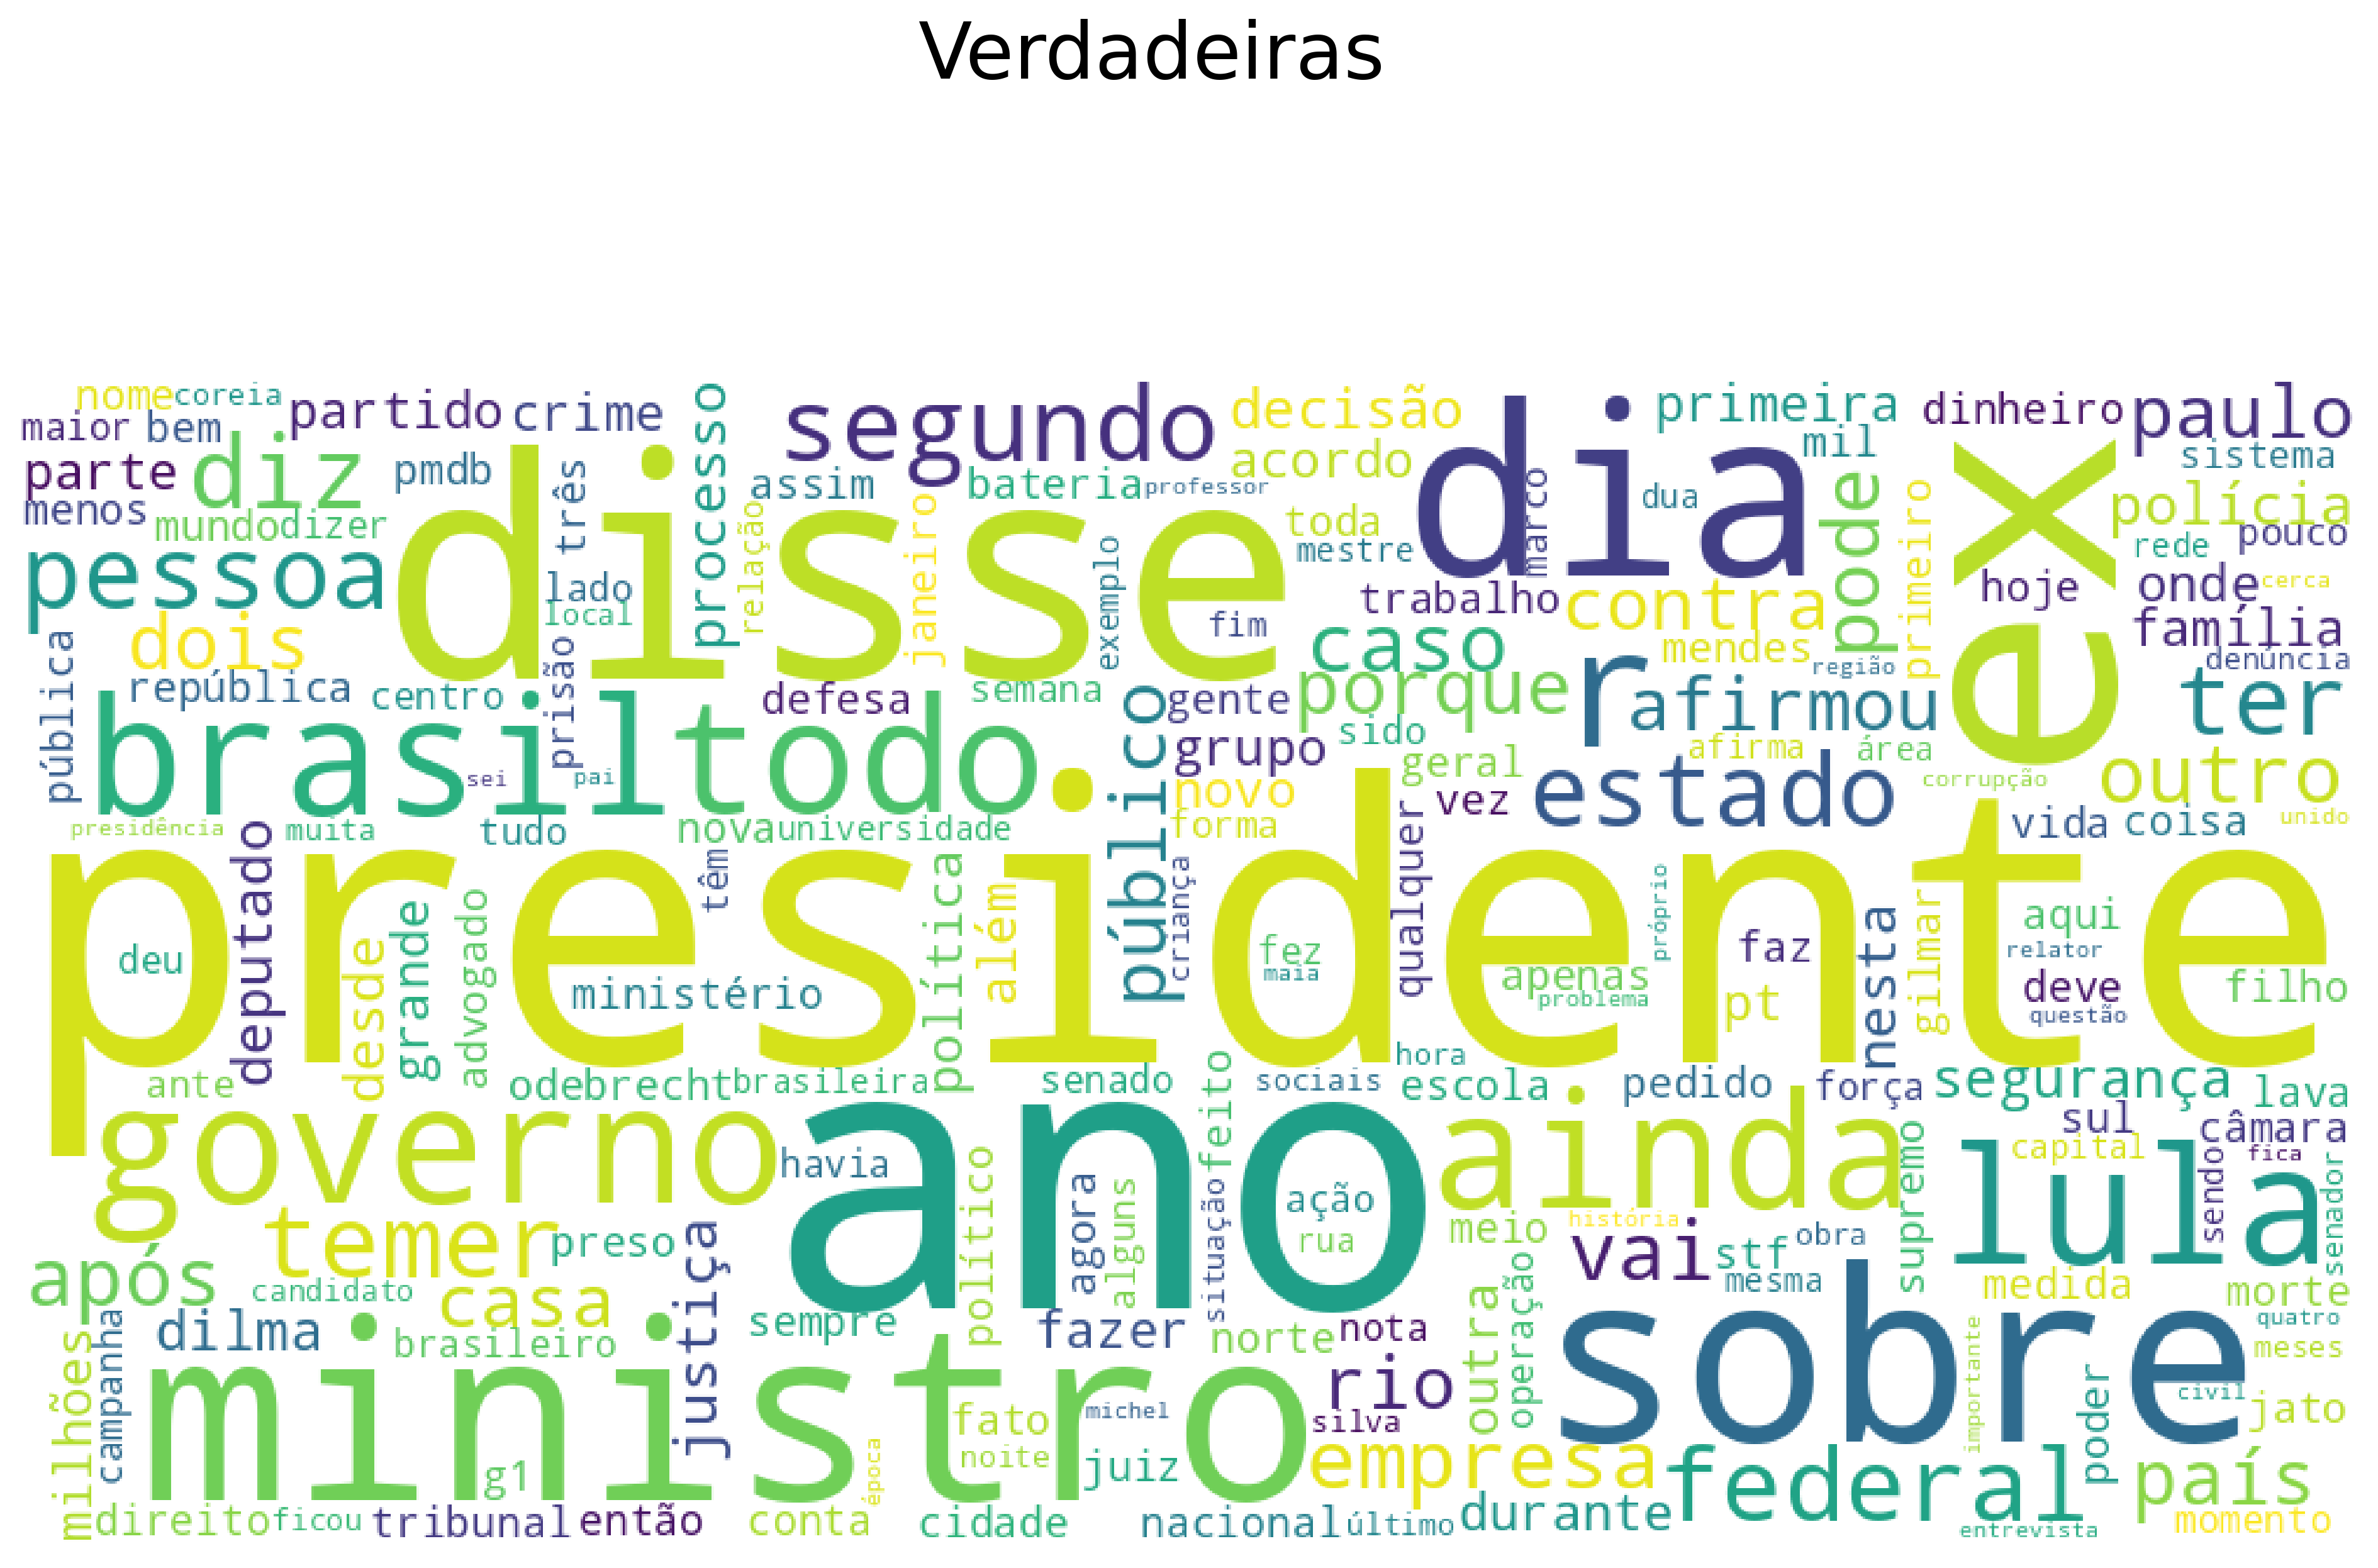

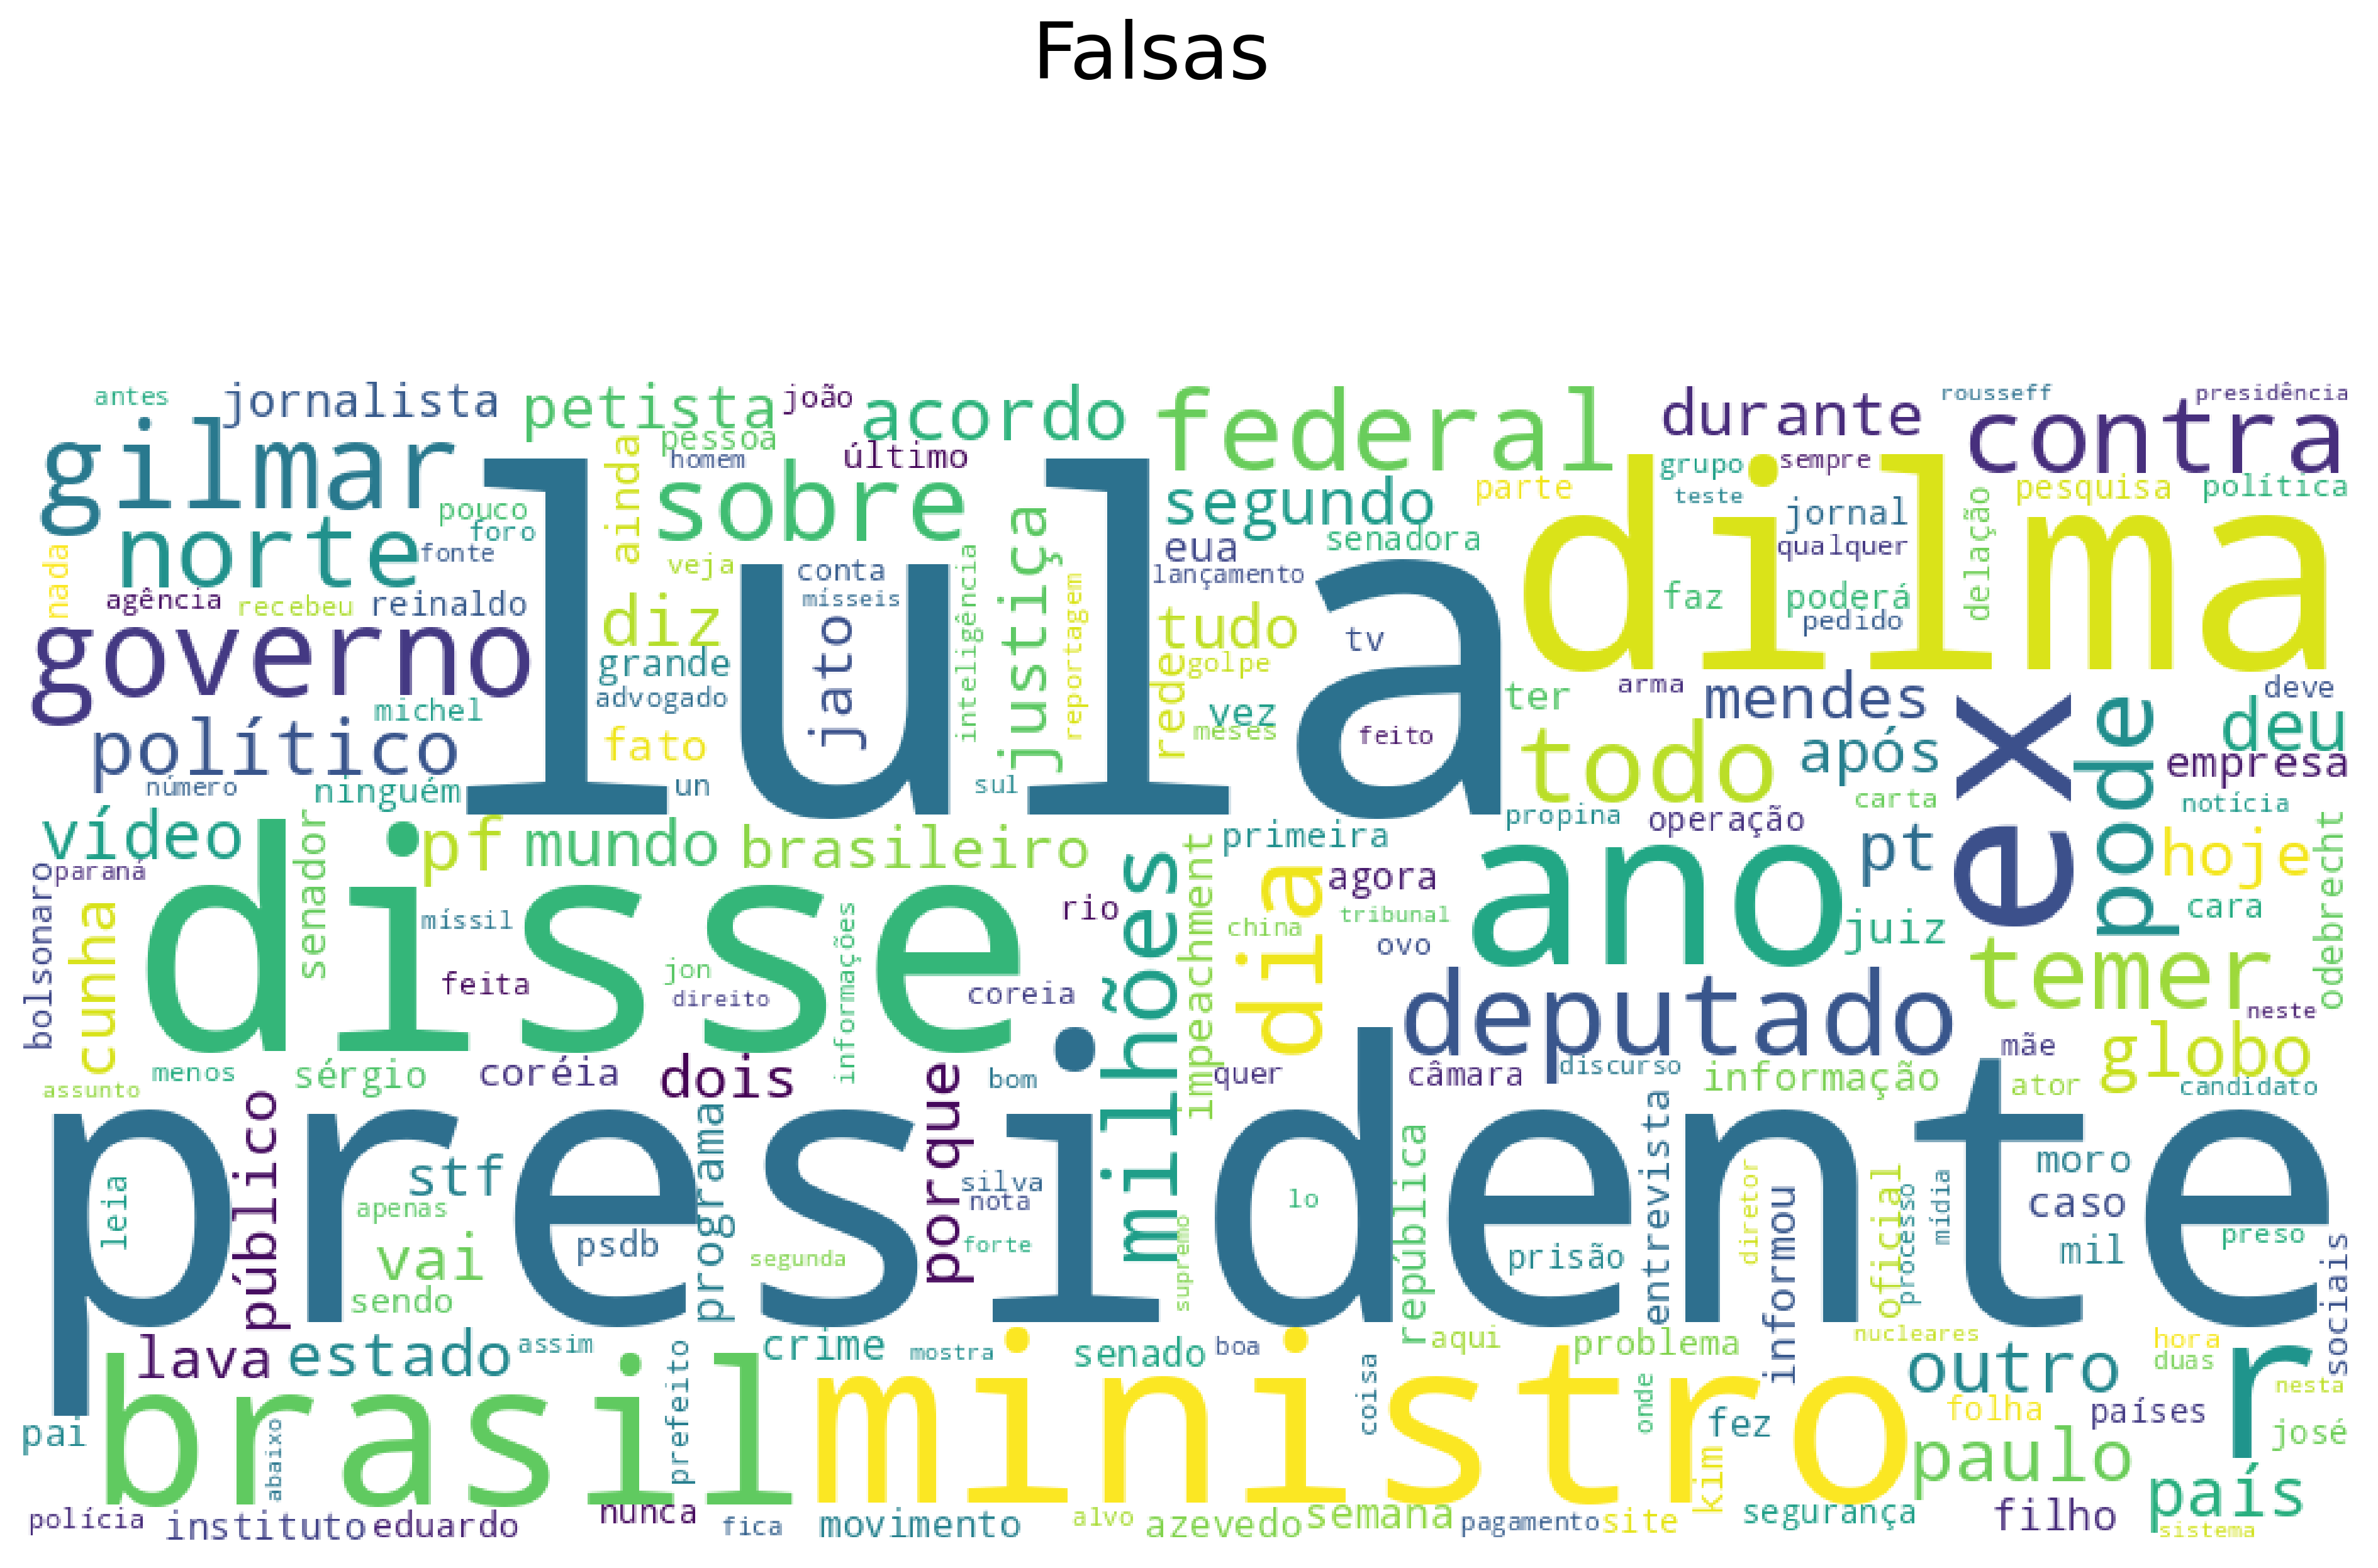

In [25]:
visualize.show_wordcloud(news_df[news_df.label == 'true'].clean_text[0:100], 
               stop, title = 'Verdadeiras')

visualize.show_wordcloud(news_df[news_df.label == 'fake'].clean_text[0:100], 
               stop, title = 'Falsas')

plt.show()

- *Observamos que alguns vocábulos são bastante frequentes tanto em notícias falsas e verdadeiras, eles centram ao redor de cargos políticos("presidente"), figuras políticas como o ex-vice-presidente Michel Temer e o ex-presidente Lula ("temer", "lula"), país("Brasil") e o descritivo "ex" para os diversos ex-ocupantes de cargos.*

- *Alguns ainda são mais frequentes em notícias falsas, como: o nome do ministro do STF Gilmar Mendes ("gilmar"), da ex-presidenta Dilma Roussef ("dilma").*

- *As mais frequentes em notícias verdadeiras também são frequentes em notícias falsas.*

Em termos de frequência na nuvem de palavras, são alguns dos termos empregados em notícias falsas que se destacam, já que tantas palavras de notícias verdadeiras também são vistas em notícias falsas.

### N-gramas
- Em que contextos as palavras são usadas?

In [26]:
news_df['clean_text'] = news_df['clean_text'].apply(lambda c: process.remove_weekday(c))
#news_df['clean_clean_text']
news_df.sample(10)

,text,label,clean_text,text_length,mean_word_len,text_size
4401,Lula está passando mal e pode ser internado. D...,fake,lula está passando mal e pode ser internado de...,972,5.081250,160
3185,'É inaceitável que um poder queira acuar o out...,true,é inaceitável que um poder queira acuar o outr...,8444,5.128447,1378
3061,O operador de propinas Fernando Antonio Falcã...,true,o operador de propinas fernando antonio falcã...,7656,4.880184,1302
4054,CUIDADO! PL 280 (proposto por senador citado n...,fake,cuidado pl 280 proposto por senador citado na ...,1764,5.192982,285
4589,Áudio mostra conversa dentro do quarto de hote...,fake,áudio mostra conversa dentro do quarto de hote...,550,4.565657,99
5650,Número de fuzilados durante o regime de Fidel ...,fake,número de fuzilados durante o regime de fidel ...,1421,4.733871,248
4381,Deputado chora ao comentar Reforma da Previdên...,fake,deputado chora ao comentar reforma da previdên...,2449,4.861244,418
3176,"Crivella pede militares, mas Jungmann diz que ...",true,crivella pede militares mas jungmann diz que n...,4171,4.778393,722
7158,"Globo afasta Otaviano Costa por ""machismo"". A...",fake,globo afasta otaviano costa por machismo a sem...,95,5.333333,15
4372,"O dia que Mainardi ""esfolou"" Eike Batista: ""Ho...",fake,o dia que mainardi esfolou eike batista homem ...,626,4.648649,111


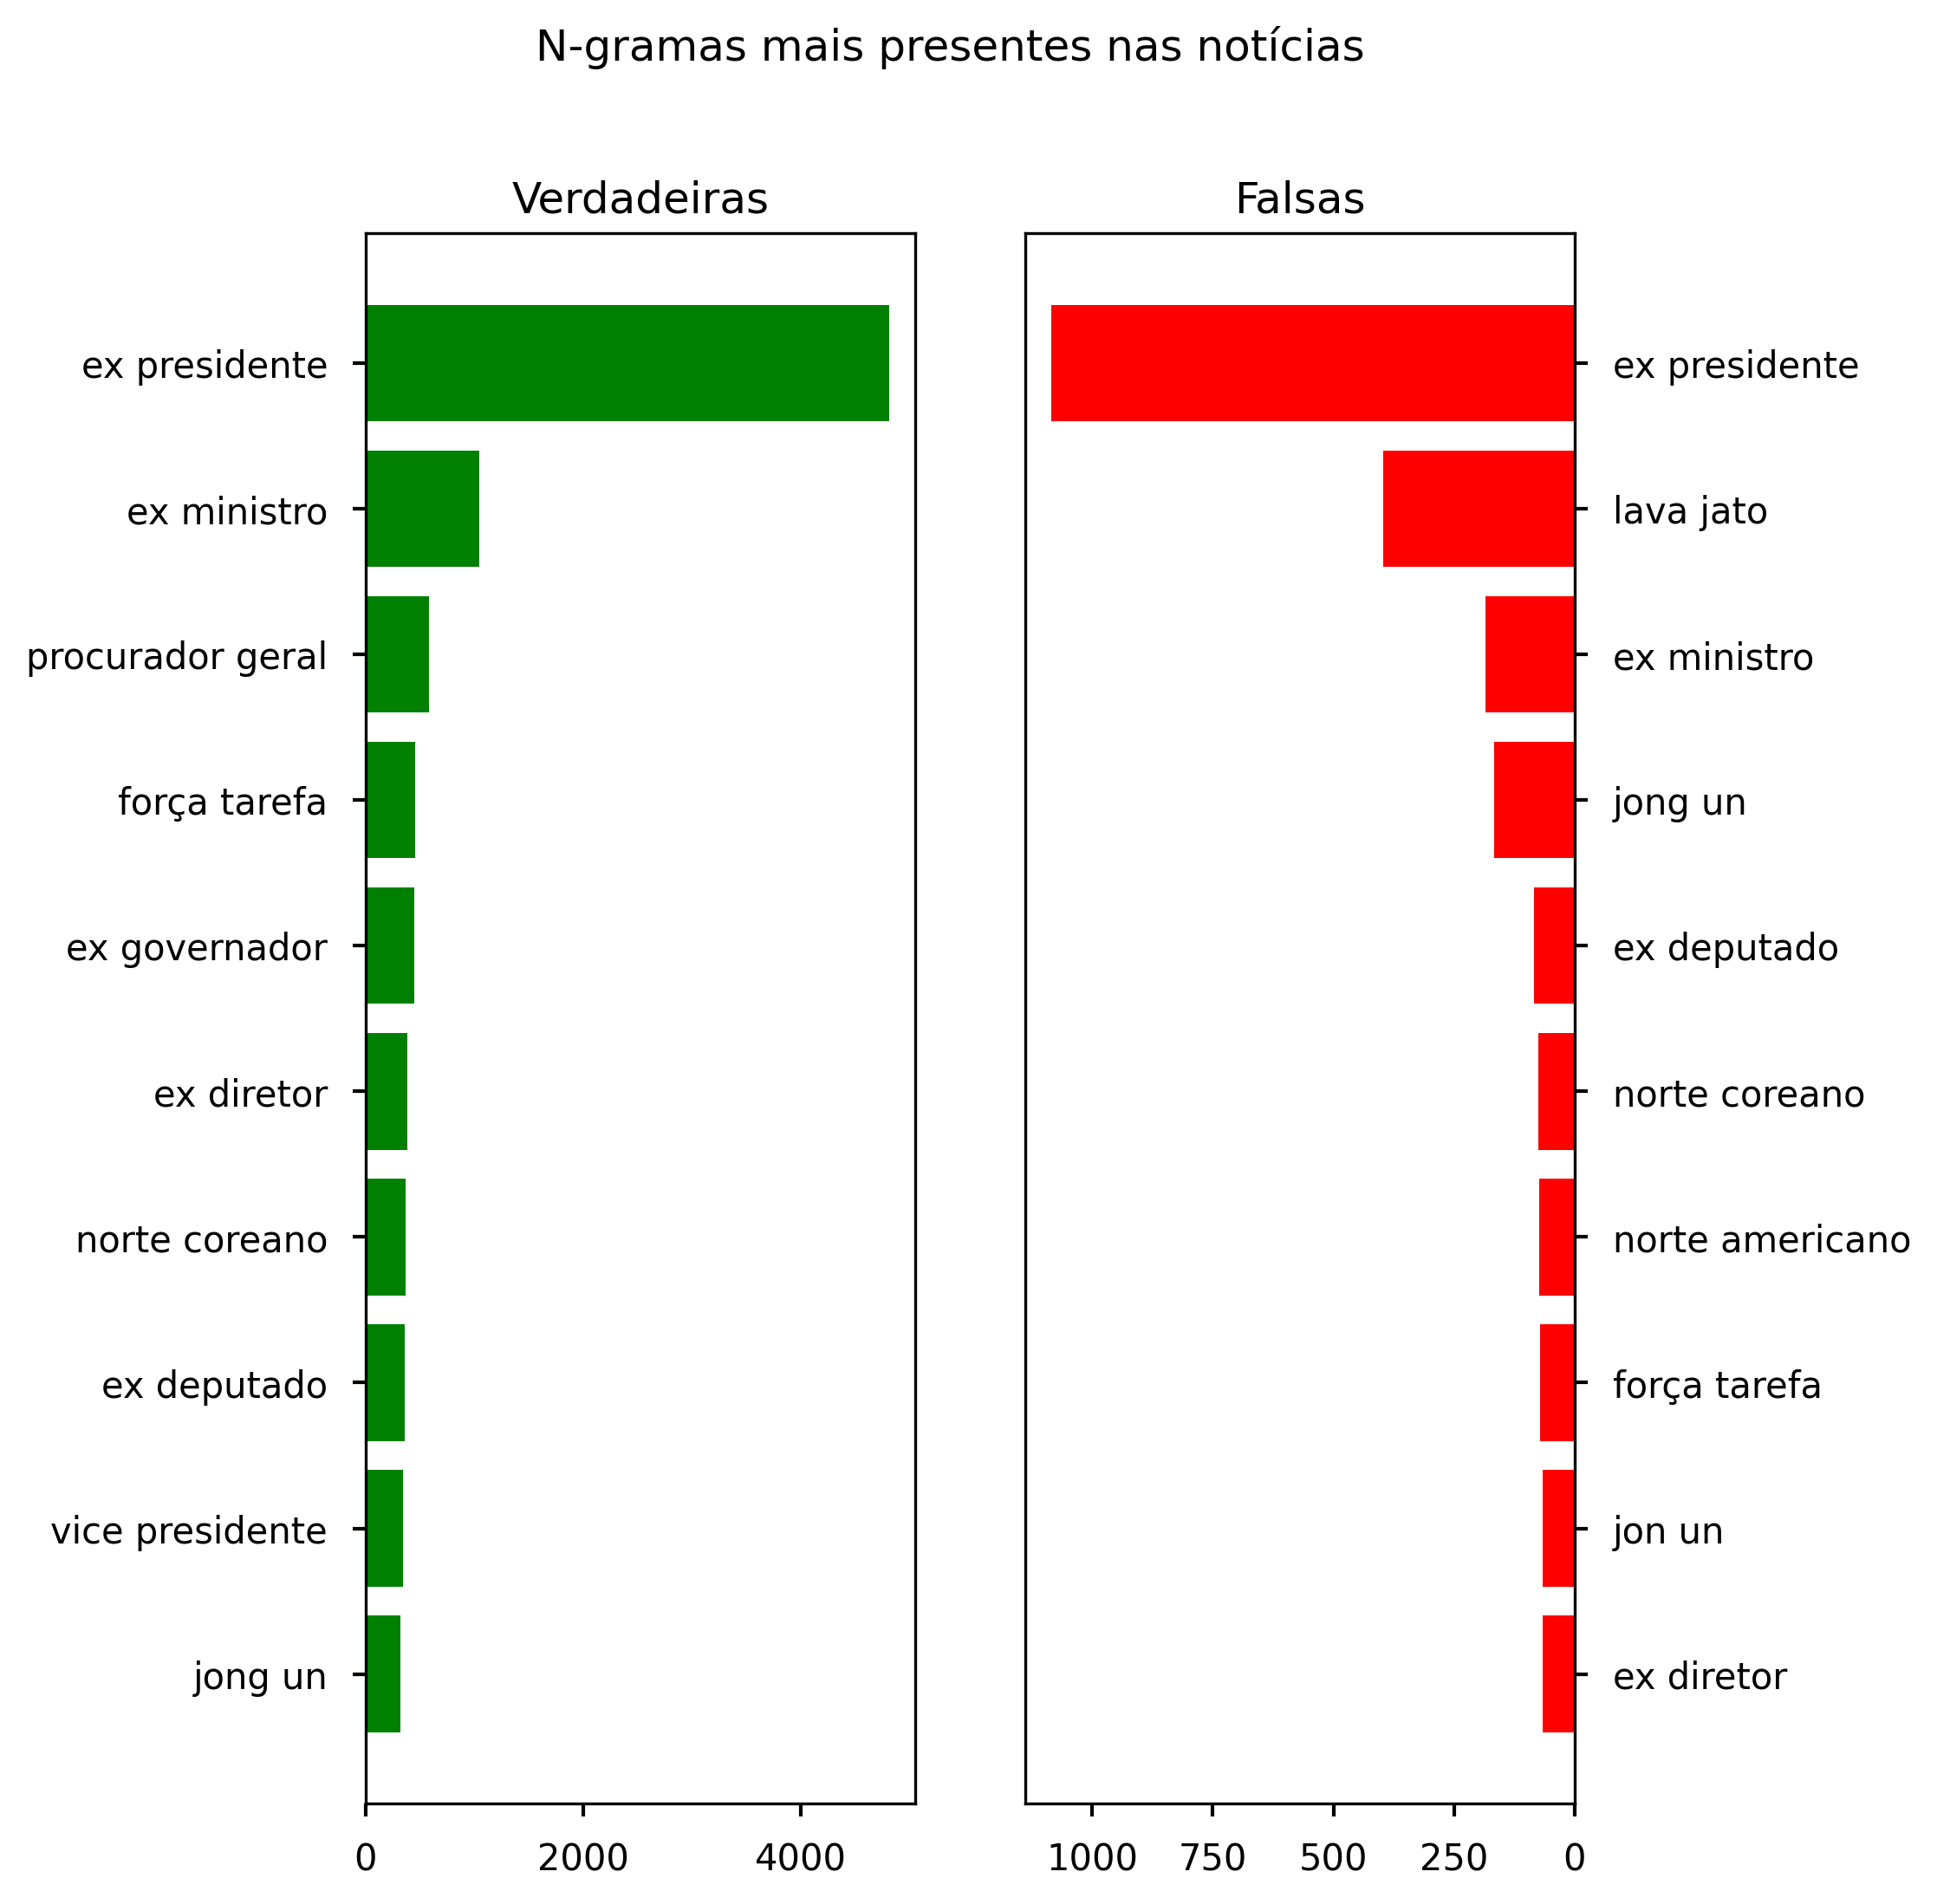

In [27]:
true_corpus = process.create_corpus(news_df[news_df.label == 'true'].clean_text)
fake_corpus = process.create_corpus(news_df[news_df.label == 'fake'].clean_text)

true_n_gram = process.get_top_ngram(corpus = true_corpus, n=2, top=10, stop_words=stop)
fake_n_gram = process.get_top_ngram(corpus = fake_corpus, n=2, top=10, stop_words=stop)

visualize.show_ngrams(true_n_gram, fake_n_gram)

*Podemos observar que em ambas as categorias, se faz referência a "ex presidente" e a ocupantes anteriores de cargos ("ex ministro", "ex deputado", "ex governador"), havendo também em ambas as notícias a menção de "norte-coreano" e a família jong-un. É interessante notar uma escrita não-padrão ou errônea do nome do líder norte-coreano sendo realizada com frequência em notícias falsas ('jon un').* 

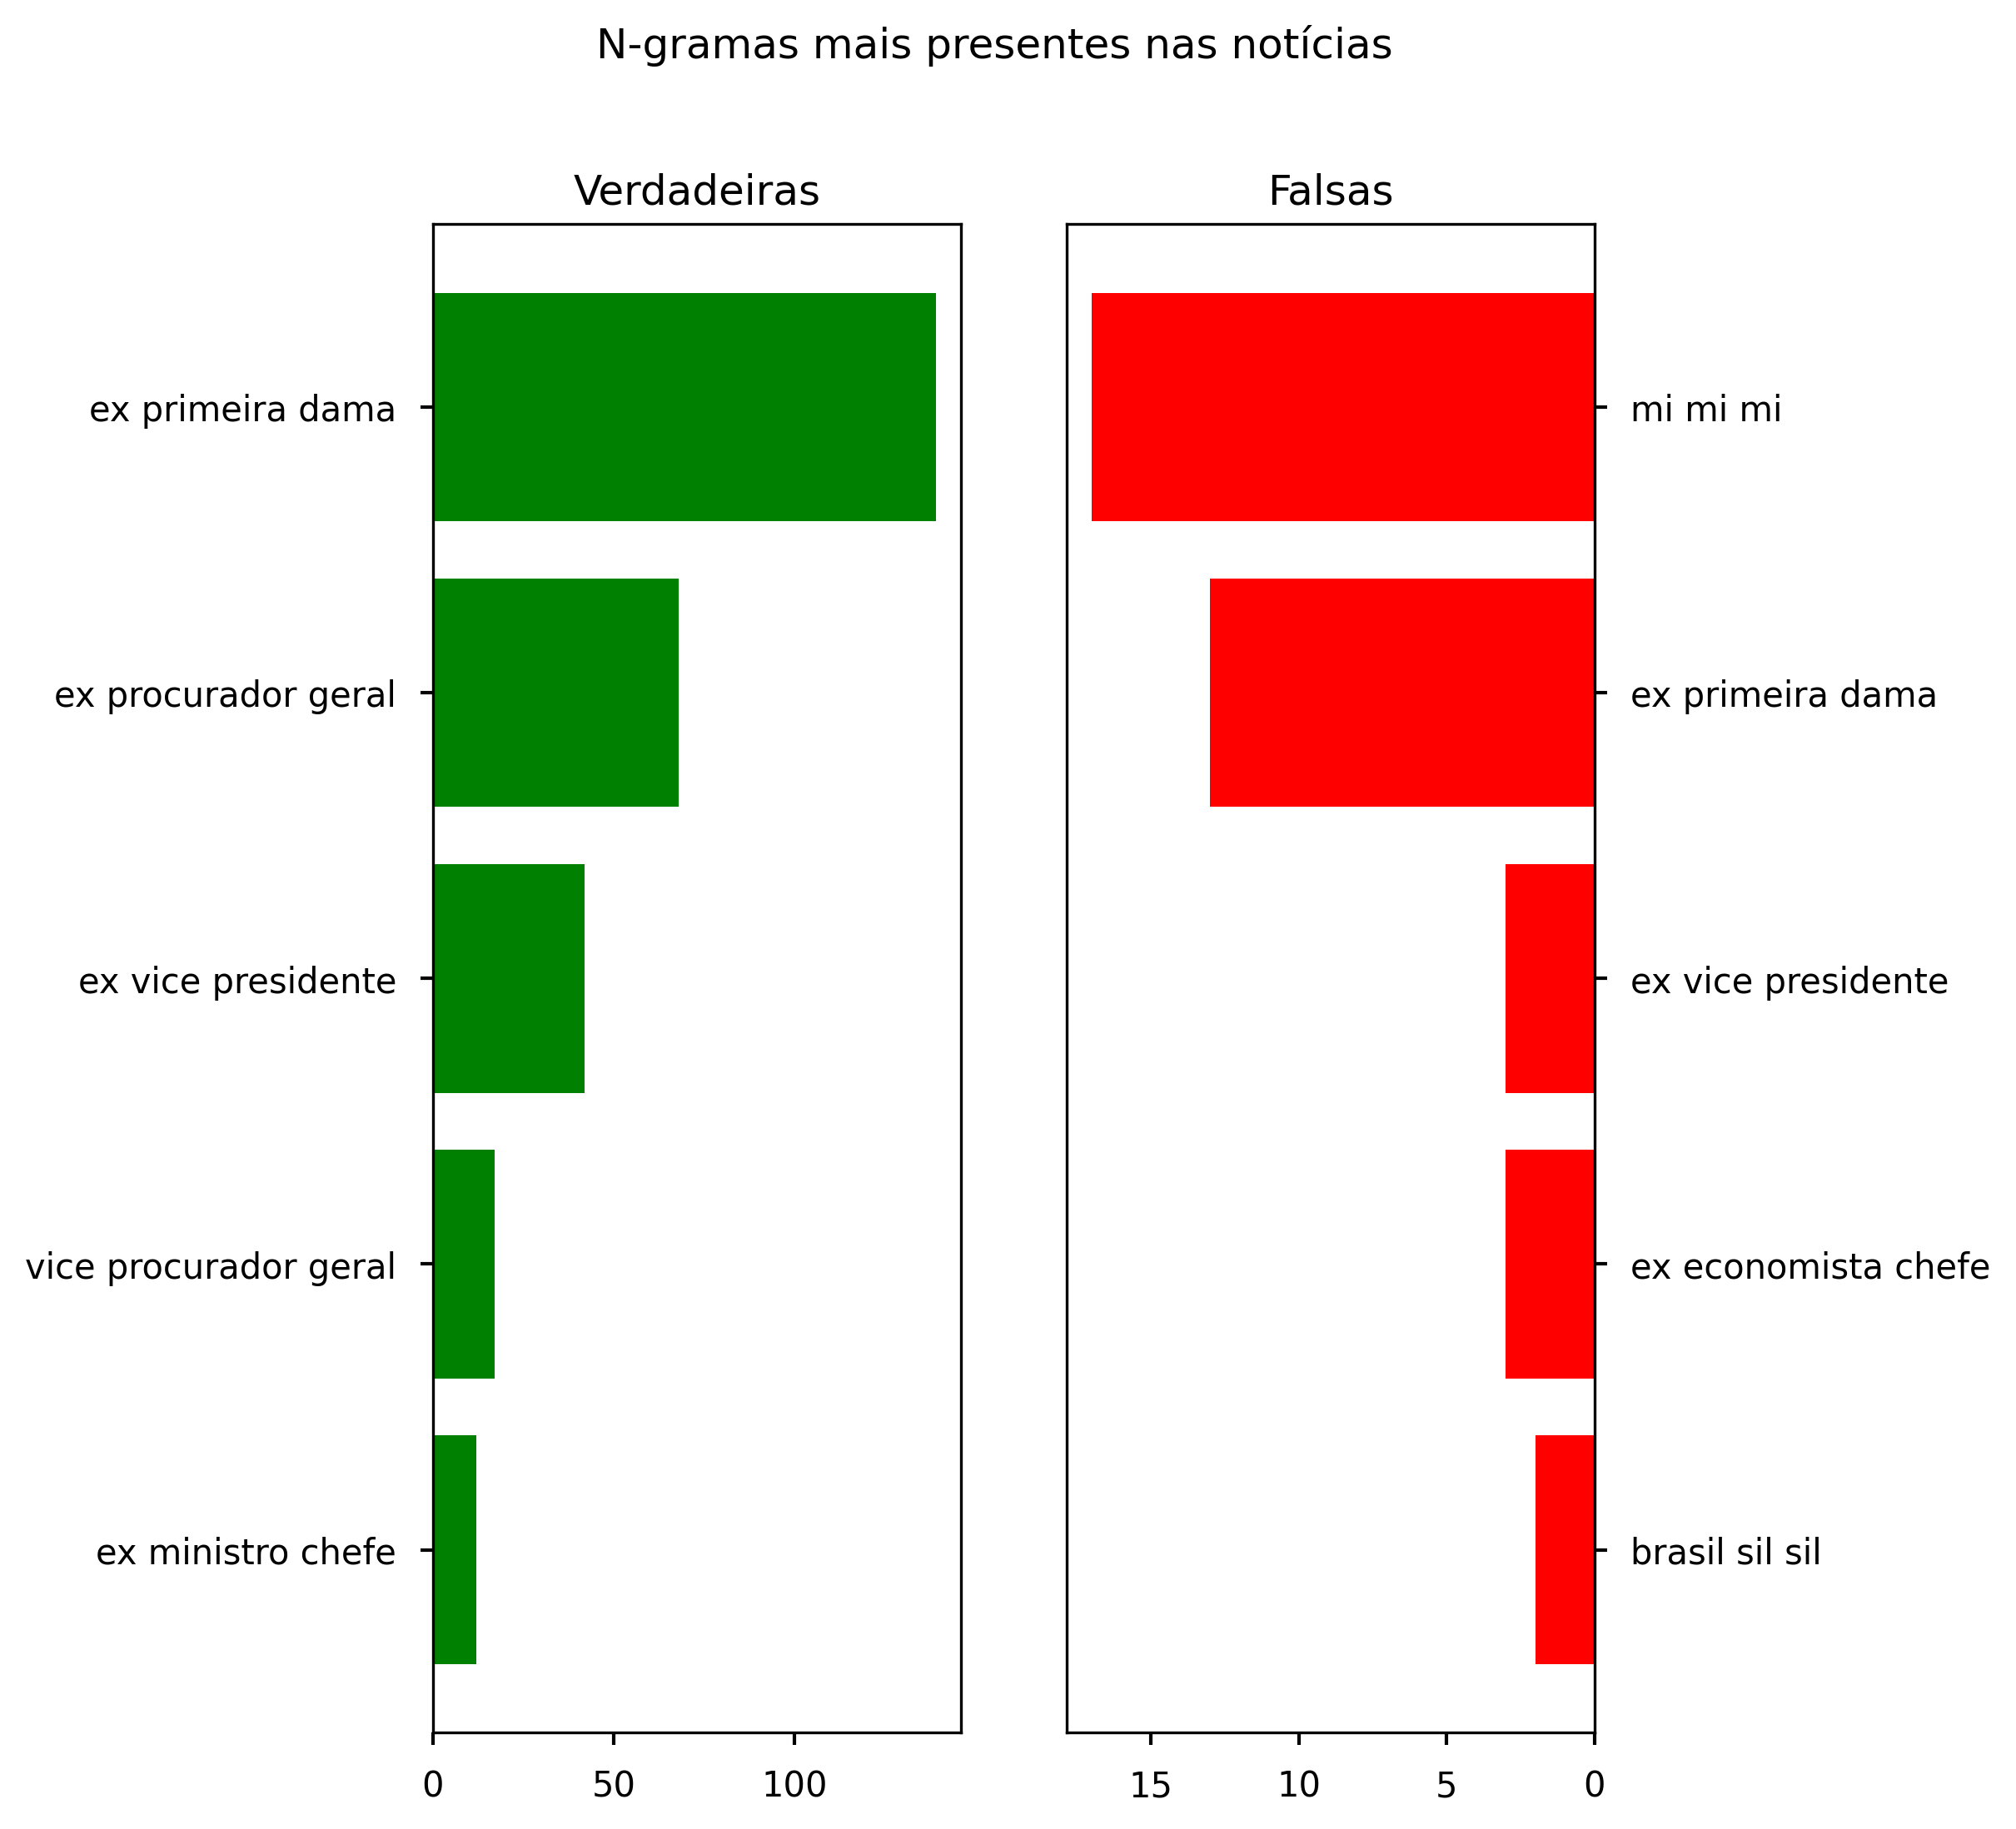

In [28]:
true_n_gram = process.get_top_ngram(corpus = true_corpus, n=3, top=5, stop_words=stop)
fake_n_gram = process.get_top_ngram(corpus = fake_corpus, n=3, top=5, stop_words=stop)

visualize.show_ngrams(true_n_gram, fake_n_gram)

*Observamos também nas notícias falsas vocabulários informais ('mi-mi-mi', 'brasil-sil-sil'), não ocorrendo nas notícias verdadeiras. Este primeiro é um jargão popular em alguns grupos da sociedade para "imitar ou descrever alguém que reclama demais" $^1$, na perspectiva de quem escreve.*

$^1$ : [Ciberdúvidas da Língua Portuguesa - consultado em 27-05-2022](https://ciberduvidas.iscte-iul.pt/consultorio/perguntas/a-expressao-mi-mi-mi/36278)

### Razão entre a proporção das palavras

- Quais palavras são mais comuns em notícias verdadeiras e, ao mesmo tempo, menos comuns em notícias falsas (e vice-versa)?

In [29]:
# Cria lista com todas as palavras de ambos os corpus
all_words = (set(true_corpus+fake_corpus))
all_words = [word for word in all_words if word not in stop]
len(all_words)

106553

In [30]:
# Pega proporção (em %) de cada palavra de cada corpus 
true_Counter = Counter(true_corpus)
true_part = [(i, true_Counter[i] / len(true_corpus) * 100.0) for i in true_Counter]
true_part = dict(true_part)

fake_Counter = Counter(fake_corpus)
fake_part =[(i, fake_Counter[i] / len(fake_corpus) * 100.0) for i in fake_Counter]
fake_part = dict(fake_part)

In [31]:
# Calcula a razão entre a proporção das palavras presentes em ambos os corpus
ratio_words = {}
for word in all_words:
    if word in true_part.keys():
        if word in fake_part.keys():
            ratio_words[word] = true_part[word]/fake_part[word]
    #     else:
    #         ratio_words[word] = float('inf')
    # else:
    #     ratio_words[word] = float('-inf')
#ratio_words

# Quanto maior o número, mais frequente a palavra é em notícias verdadeiras, e + rara em falsas
ratio_words = dict(sorted(ratio_words.items(), key=lambda item: item[1], reverse=True))

In [32]:
# Quanto maior o número, mais frequente a palavra é em notícias falsas e rara em verdadeiras
inverse_ratio_words = {}
for word in ratio_words:
    inverse_ratio_words[word] = 1/ratio_words[word]
    
inverse_ratio_words = dict(sorted(inverse_ratio_words.items(), key=lambda item: item[1], reverse=True))    

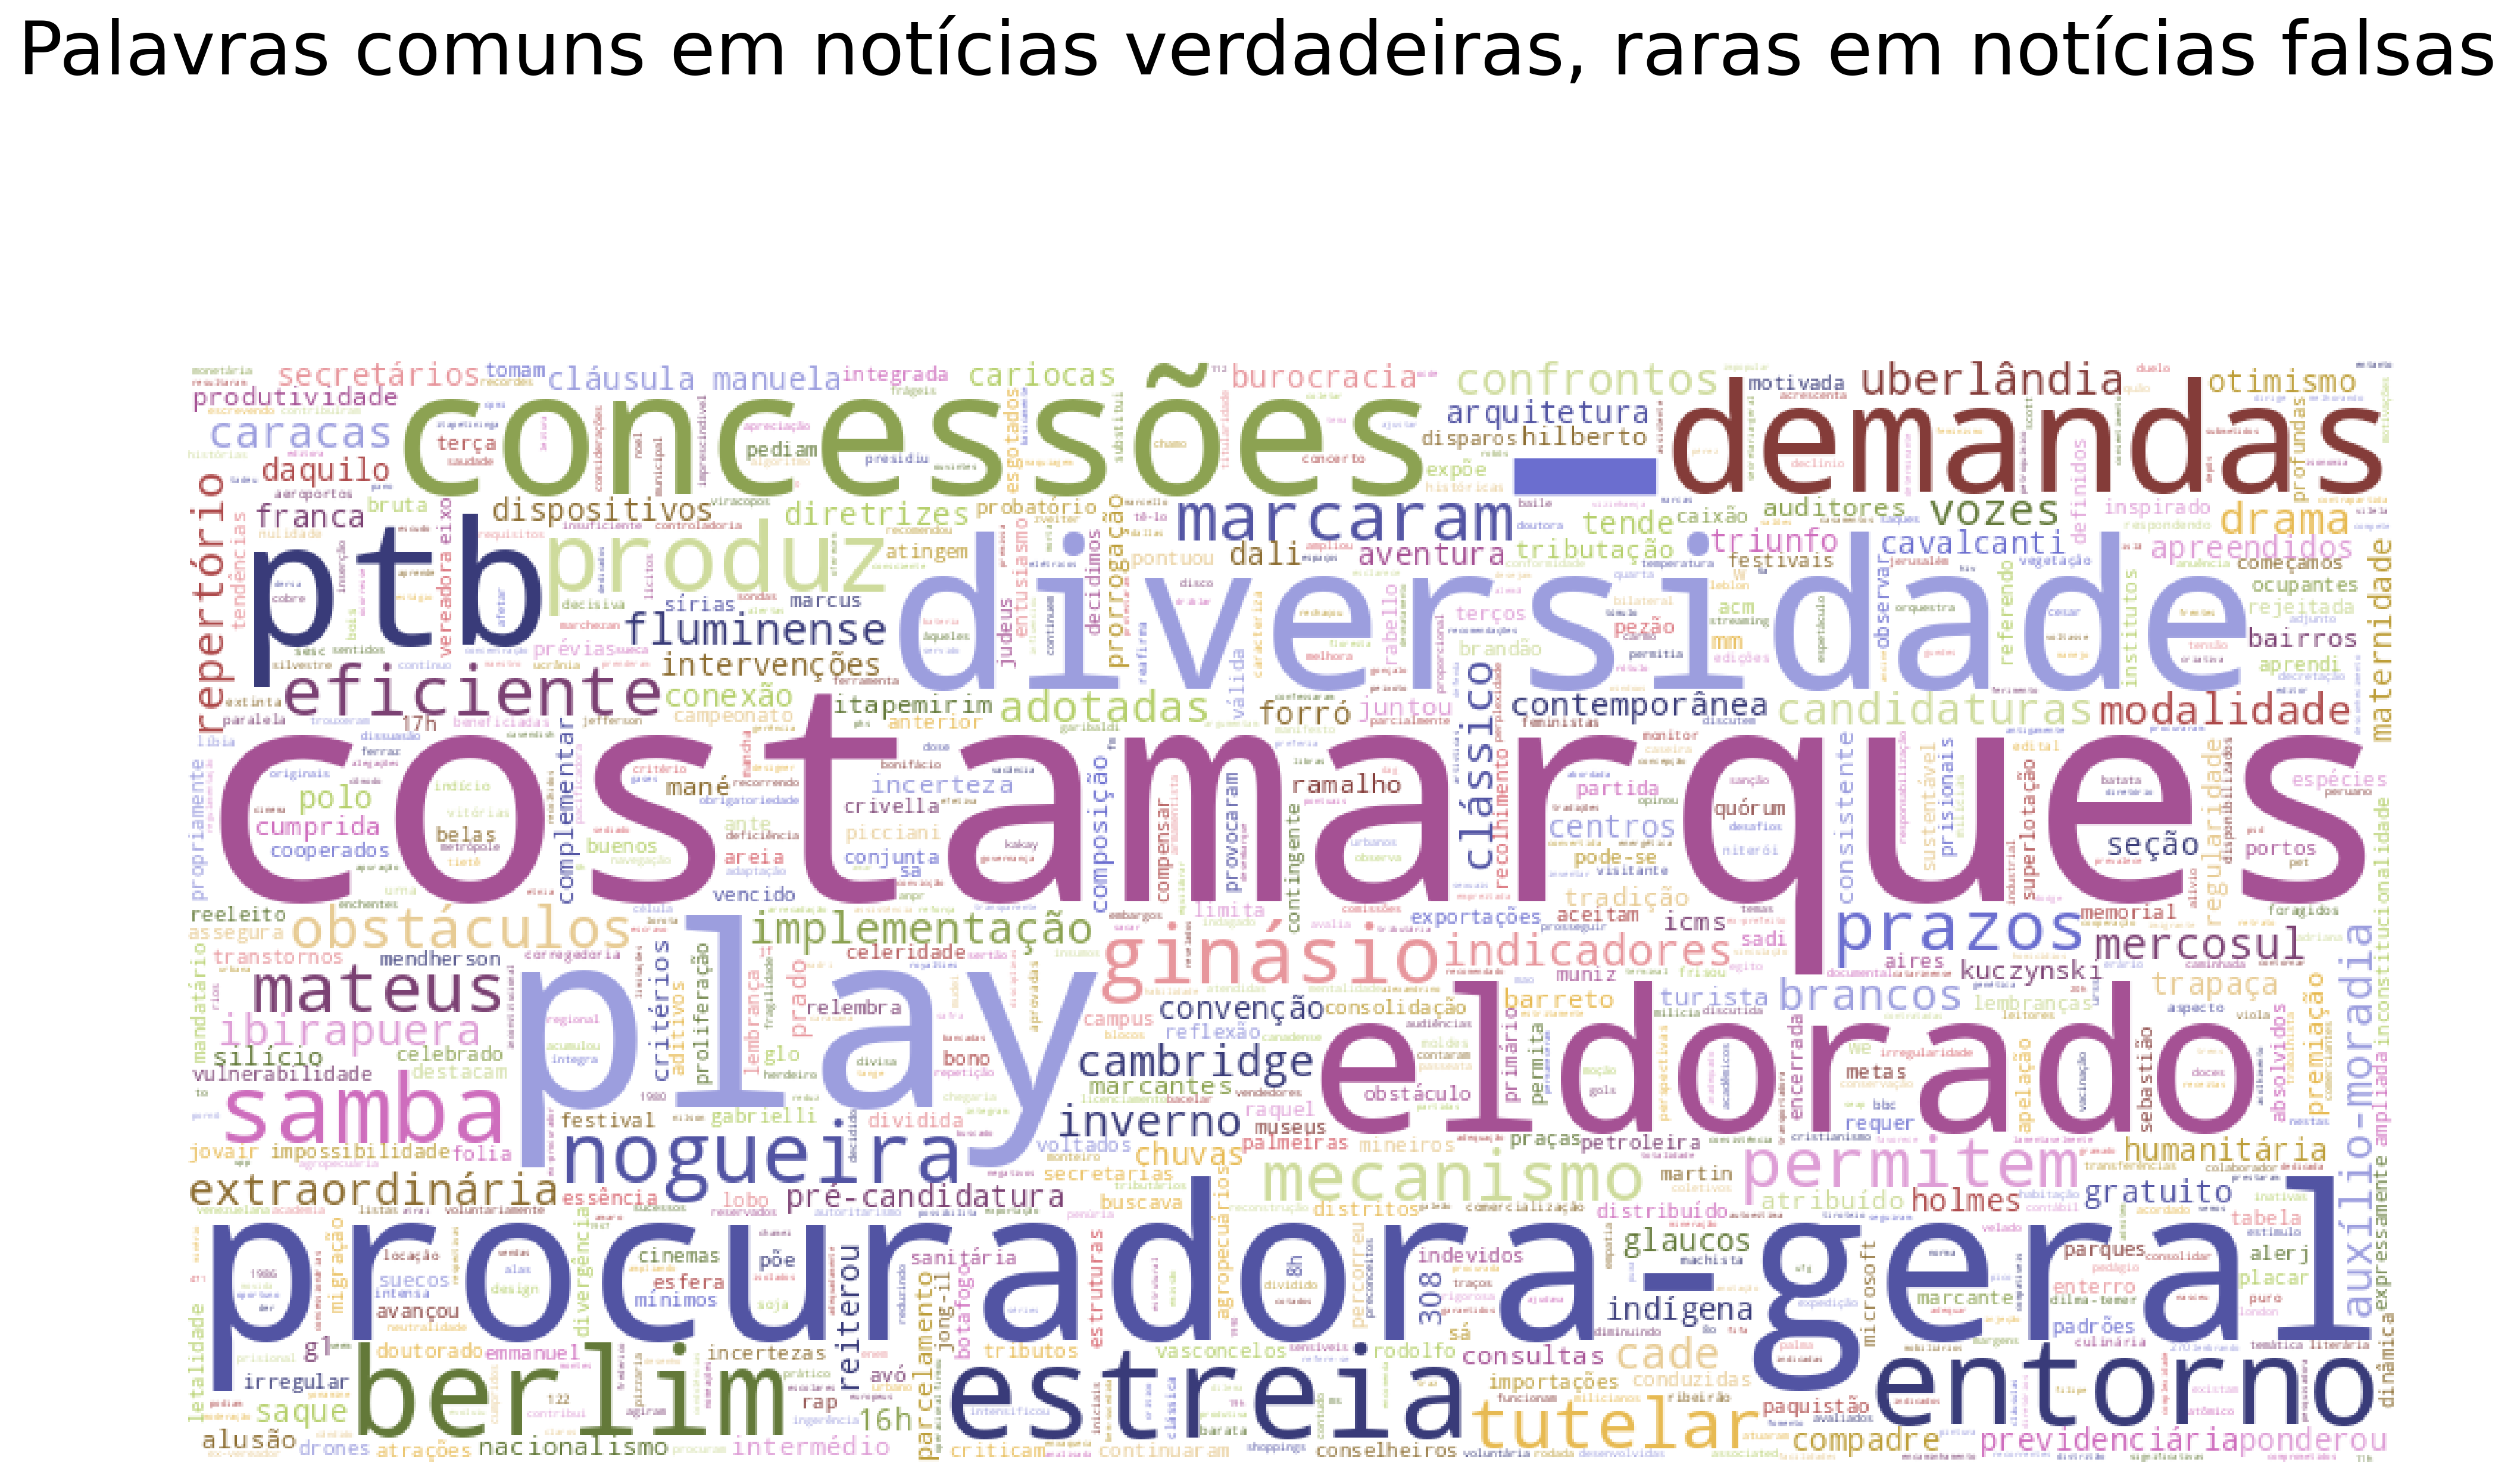

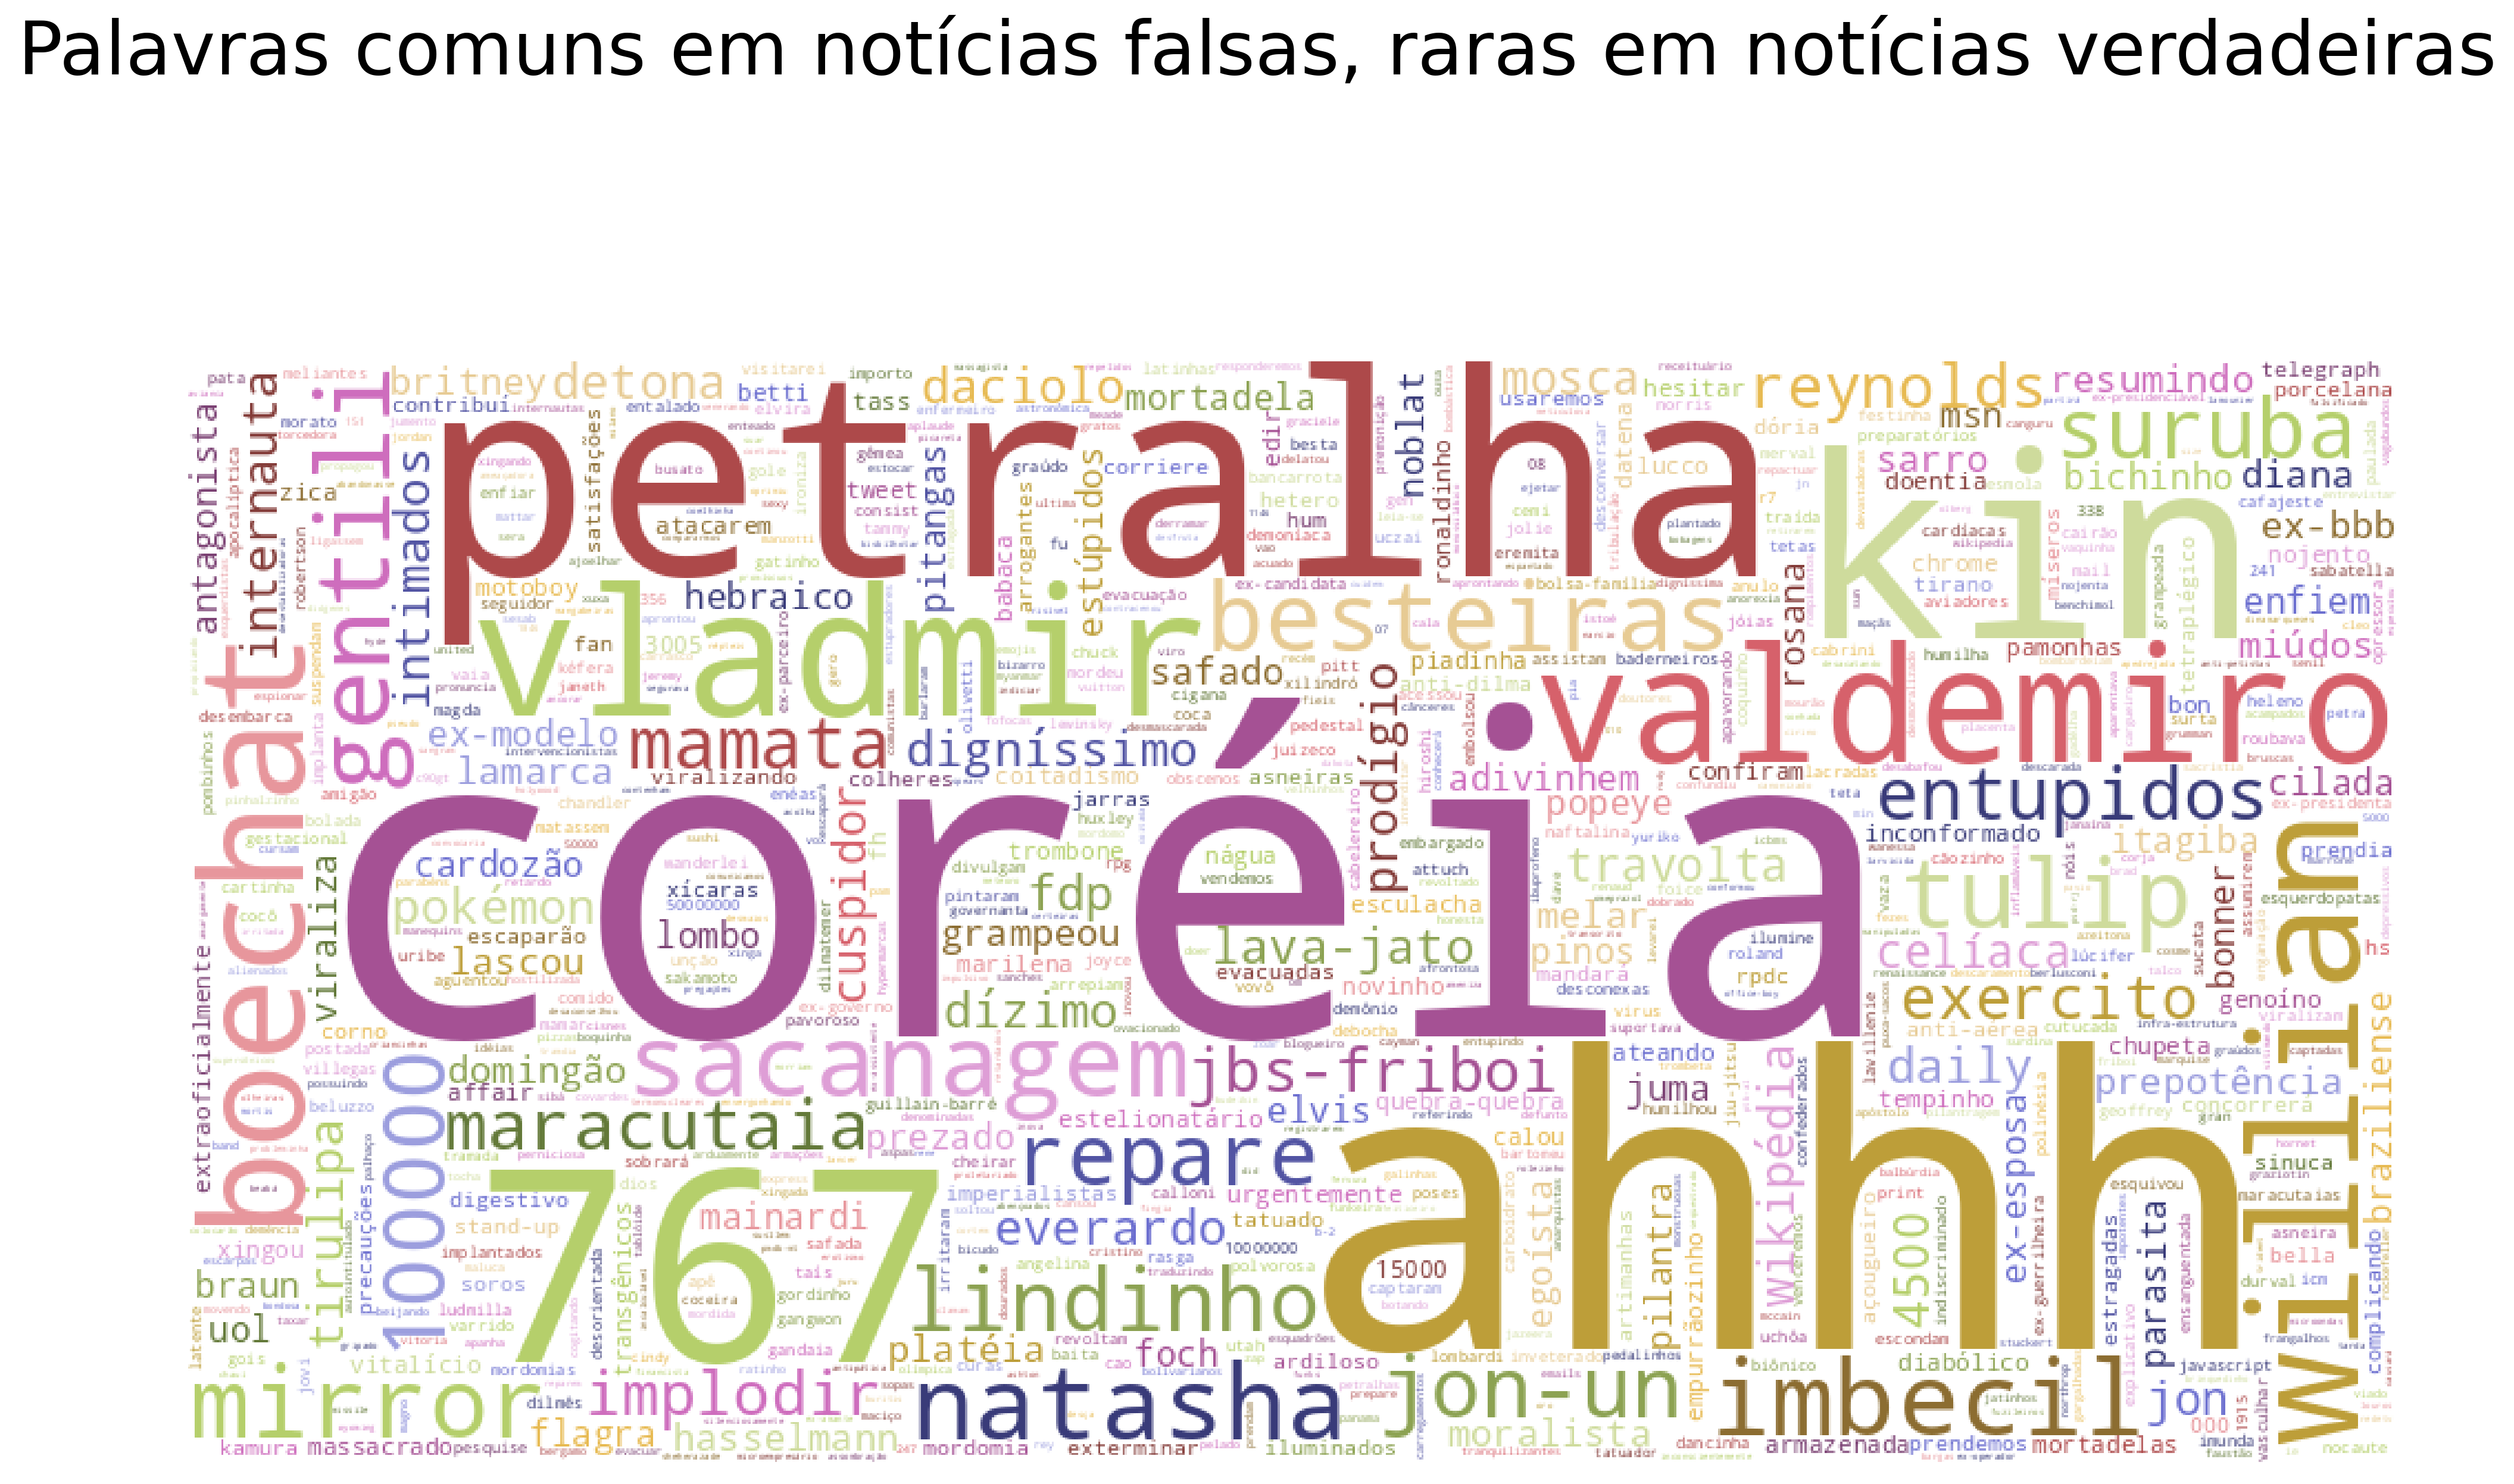

In [33]:
visualize.dict_to_wordcloud(ratio_words, title='Palavras comuns em notícias verdadeiras, raras em notícias falsas', colormap='tab20b')

visualize.dict_to_wordcloud(inverse_ratio_words, title='Palavras comuns em notícias falsas, raras em notícias verdadeiras', colormap='tab20b')

plt.show()    

- *As palavras comuns em notícias verdadeiras e raras em falsas incluem vocábulos relacionados à instituições ('procuradoria geral'), administração pública ('concessões', 'demandas'), partidos ('ptb'). Também surge o termo Costa Marques "costamarques", relacionado a "Glaucos da Costa Marques", proprietário do imóvel visitado pelo ex-presidente Lula.*

- *Já na situação oposta, encontramos mais referências à "coréia", e pelos termos comuns em bigramas e trigramas, se trata da Coreia do Norte. O termo 'petralha', adjetivo derrogativo usado para pessoas que se alinham entre a centro-esquerda e a esquerda também é comum. Referências a nomes proṕrios também são comuns: 'valdemiro', 'willian', 'vladmir' e 'kin'; estes ainda não pudemos esclarecer.*